# setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'

# functions

In [ ]:
class MLP(nn.Module):
    def __init__(self, architecture, activation='relu', dropout_p=None, use_l2=False):
        """
        `todo`
        """
        super(MLP, self).__init__()
        #
        self.n_layers = len(architecture) - 1
        self.layers = nn.ModuleList()
        self.dropout = None if dropout_p is None else nn.Dropout(dropout_p)
        self.use_l2 = use_l2
        #
        if activation.lower() == 'relu':
            self.activation = nn.ReLU()
        elif activation.lower() == 'tanh':
            self.activation = nn.Tanh()
        else:
            raise ValueError("função de ativação deve ser 'relu' ou 'tanh'")
        #
        for i in range(self.n_layers):
            self.layers.append(
                nn.Linear(architecture[i], architecture[i+1])
            )
            #
            nn.init.normal_(self.layers[i].weight, mean=0.0, std=1)
            nn.init.zeros_(self.layers[i].bias)
    
    def forward(self, x):
        """
        `todo`
        """
        for i in range(self.n_layers - 1):
            x = self.layers[i](x)
            x = self.activation(x)
            if self.dropout is not None:
                x = self.dropout(x)
        #
        x = self.layers[-1](x)
        return x

In [3]:
def get_loss_function(task='multiclass'):
    if task.lower() == 'binary':
        return nn.BCEWithLogitsLoss()
    elif task.lower() == 'multiclass':
        return nn.CrossEntropyLoss()
    else:
        raise ValueError("task must be 'binary' or 'multiclass'")


def get_optimizer(model, optimizer_type='sgd', lr=0.01, momentum=0.9, weight_decay=0):
    if optimizer_type.lower() == 'sgd':
        return optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_type.lower() == 'adam':
        return optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError("optimizer_type must be 'sgd' or 'adam'")


def get_output_size(y, task='binary'):
    if task.lower() == 'binary':
        return 1
    else:
        return len(np.unique(y))

In [9]:
def train_model(
        model,
        dataloader_train,
        dataloader_val,
        criterion,
        optimizer,
        epochs=100,
        patience=20,
        device='cpu',
        l2_lambda=0.0,
        task='multiclass'
    ):
    """
    `todo`
    """
    model.to(device)
    history = {
        'train_loss': list(),
        'train_acc': list(),
        'val_loss': list(),
        'val_acc': list()
    }
    best_val_loss = float('inf')
    counter = 0
    best_model_state = None
    #
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for inputs, targets in dataloader_train:
            inputs, targets = inputs.to(device), targets.to(device)
            # forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            #
            if task.lower() == 'binary':
                targets = targets.float()
                loss = criterion(outputs, targets)
                predicted = (outputs > 0.0).float()
            else:
                loss = criterion(outputs, targets)
                _, predicted = torch.max(outputs, 1)
            # regularization
            if model.use_l2:
                l2_reg = 0.0
                for param in model.parameters():
                    l2_reg += torch.norm(param, 2)
                loss += l2_lambda * l2_reg
            # backpropagation
            loss.backward()
            optimizer.step()
            # stats (train)
            train_loss += loss.item() * inputs.size(0)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()
        # stats
        train_loss = train_loss / train_total
        train_acc = train_correct / train_total
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, targets in dataloader_val:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                if task.lower() == 'binary':
                    targets = targets.float()
                    loss = criterion(outputs, targets)
                    predicted = (outputs > 0.0).float()
                else:
                    loss = criterion(outputs, targets)
                    _, predicted = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
        val_loss = val_loss / val_total
        val_acc = val_correct / val_total
        #
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        # print(f'Época {epoch+1}/{epochs} - Treino: perda={train_loss:.4f}, acc={train_acc:.4f} | Validação: perda={val_loss:.4f}, acc={val_acc:.4f}')
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            best_model_state = model.state_dict().copy()
        else:
            counter += 1
            if counter >= patience:
                print(f'early stopping na época {epoch+1}')
                break
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return history

In [5]:
def evaluate_model(model, dataloader_test, criterion, device='cpu', task='multiclass'):
    """
    `todo`
    """
    model.to(device)
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, targets in dataloader_test:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            if task.lower() == 'binary':
                targets = targets.float().view(-1, 1)
                loss = criterion(outputs, targets)
                predicted = (outputs > 0.0).float()
            else:
                loss = criterion(outputs, targets)
                _, predicted = torch.max(outputs, 1)
            test_loss += loss.item() * inputs.size(0)
            test_total += targets.size(0)
            test_correct += (predicted == targets).sum().item()
    test_loss = test_loss / test_total
    test_acc = test_correct / test_total
    return test_loss, test_acc

In [6]:
def prepare_classification_data(X, y, X_test=None, y_test=None, val_size=0.2, batch_size=32, task='binary', convert_labels=False):
    """
    `todo`
    """
    if X_test is not None and y_test is not None:
        X_train_val, y_train_val = X, y
    else:
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, 
        test_size=val_size,
        random_state=42, 
        stratify=y_train_val
    )
    if convert_labels:
        y_train = (y_train == 1).astype(int)
        y_val = (y_val == 1).astype(int)
        y_test = (y_test == 1).astype(int)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    X_train_tensor = torch.FloatTensor(X_train)
    X_val_tensor = torch.FloatTensor(X_val)
    X_test_tensor = torch.FloatTensor(X_test)
    if task.lower() == 'binary':
        y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
        y_val_tensor = torch.FloatTensor(y_val).view(-1, 1)
        y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)
    else:
        y_train_tensor = torch.LongTensor(y_train)
        y_val_tensor = torch.LongTensor(y_val)
        y_test_tensor = torch.LongTensor(y_test)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    return train_loader, val_loader, test_loader

# 3.1

## analysis

In [7]:
i = 2
train = pd.read_csv(f"../data/atividade_01/train_dataset{i}.csv")
test = pd.read_csv(f"../data/atividade_01/test_dataset{i}.csv")
display(train.head())
display(test.head())

X_train = train.iloc[:, :-1].values
y_train = train.iloc[:, -1].values
X_test = test.iloc[:, :-1].values
y_test = test.iloc[:, -1].values

task = 'binary'
input_features = X_train.shape[1]
output_size = get_output_size(y_train, task=task)

train_loader, val_loader, test_loader = prepare_classification_data(
    X_train, 
    y_train, 
    X_test = X_test, 
    y_test = y_test,
    batch_size = 32,
    task = task,
    convert_labels = True
)

x1        x2  label
0 -0.882159 -0.511697     -1
1  0.056971  0.101538      1
2  0.987759 -0.000616     -1
3  1.108407  0.017528     -1
4 -0.555163  0.770001     -1

x1        x2  label
0 -0.141852  0.102203      1
1  0.134028 -1.027246     -1
2  0.171773 -0.896942     -1
3  0.071050 -0.193340      1
4 -0.829970  0.547396     -1

### layers

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:23<00:00,  2.91s/it]

early stopping na época 384


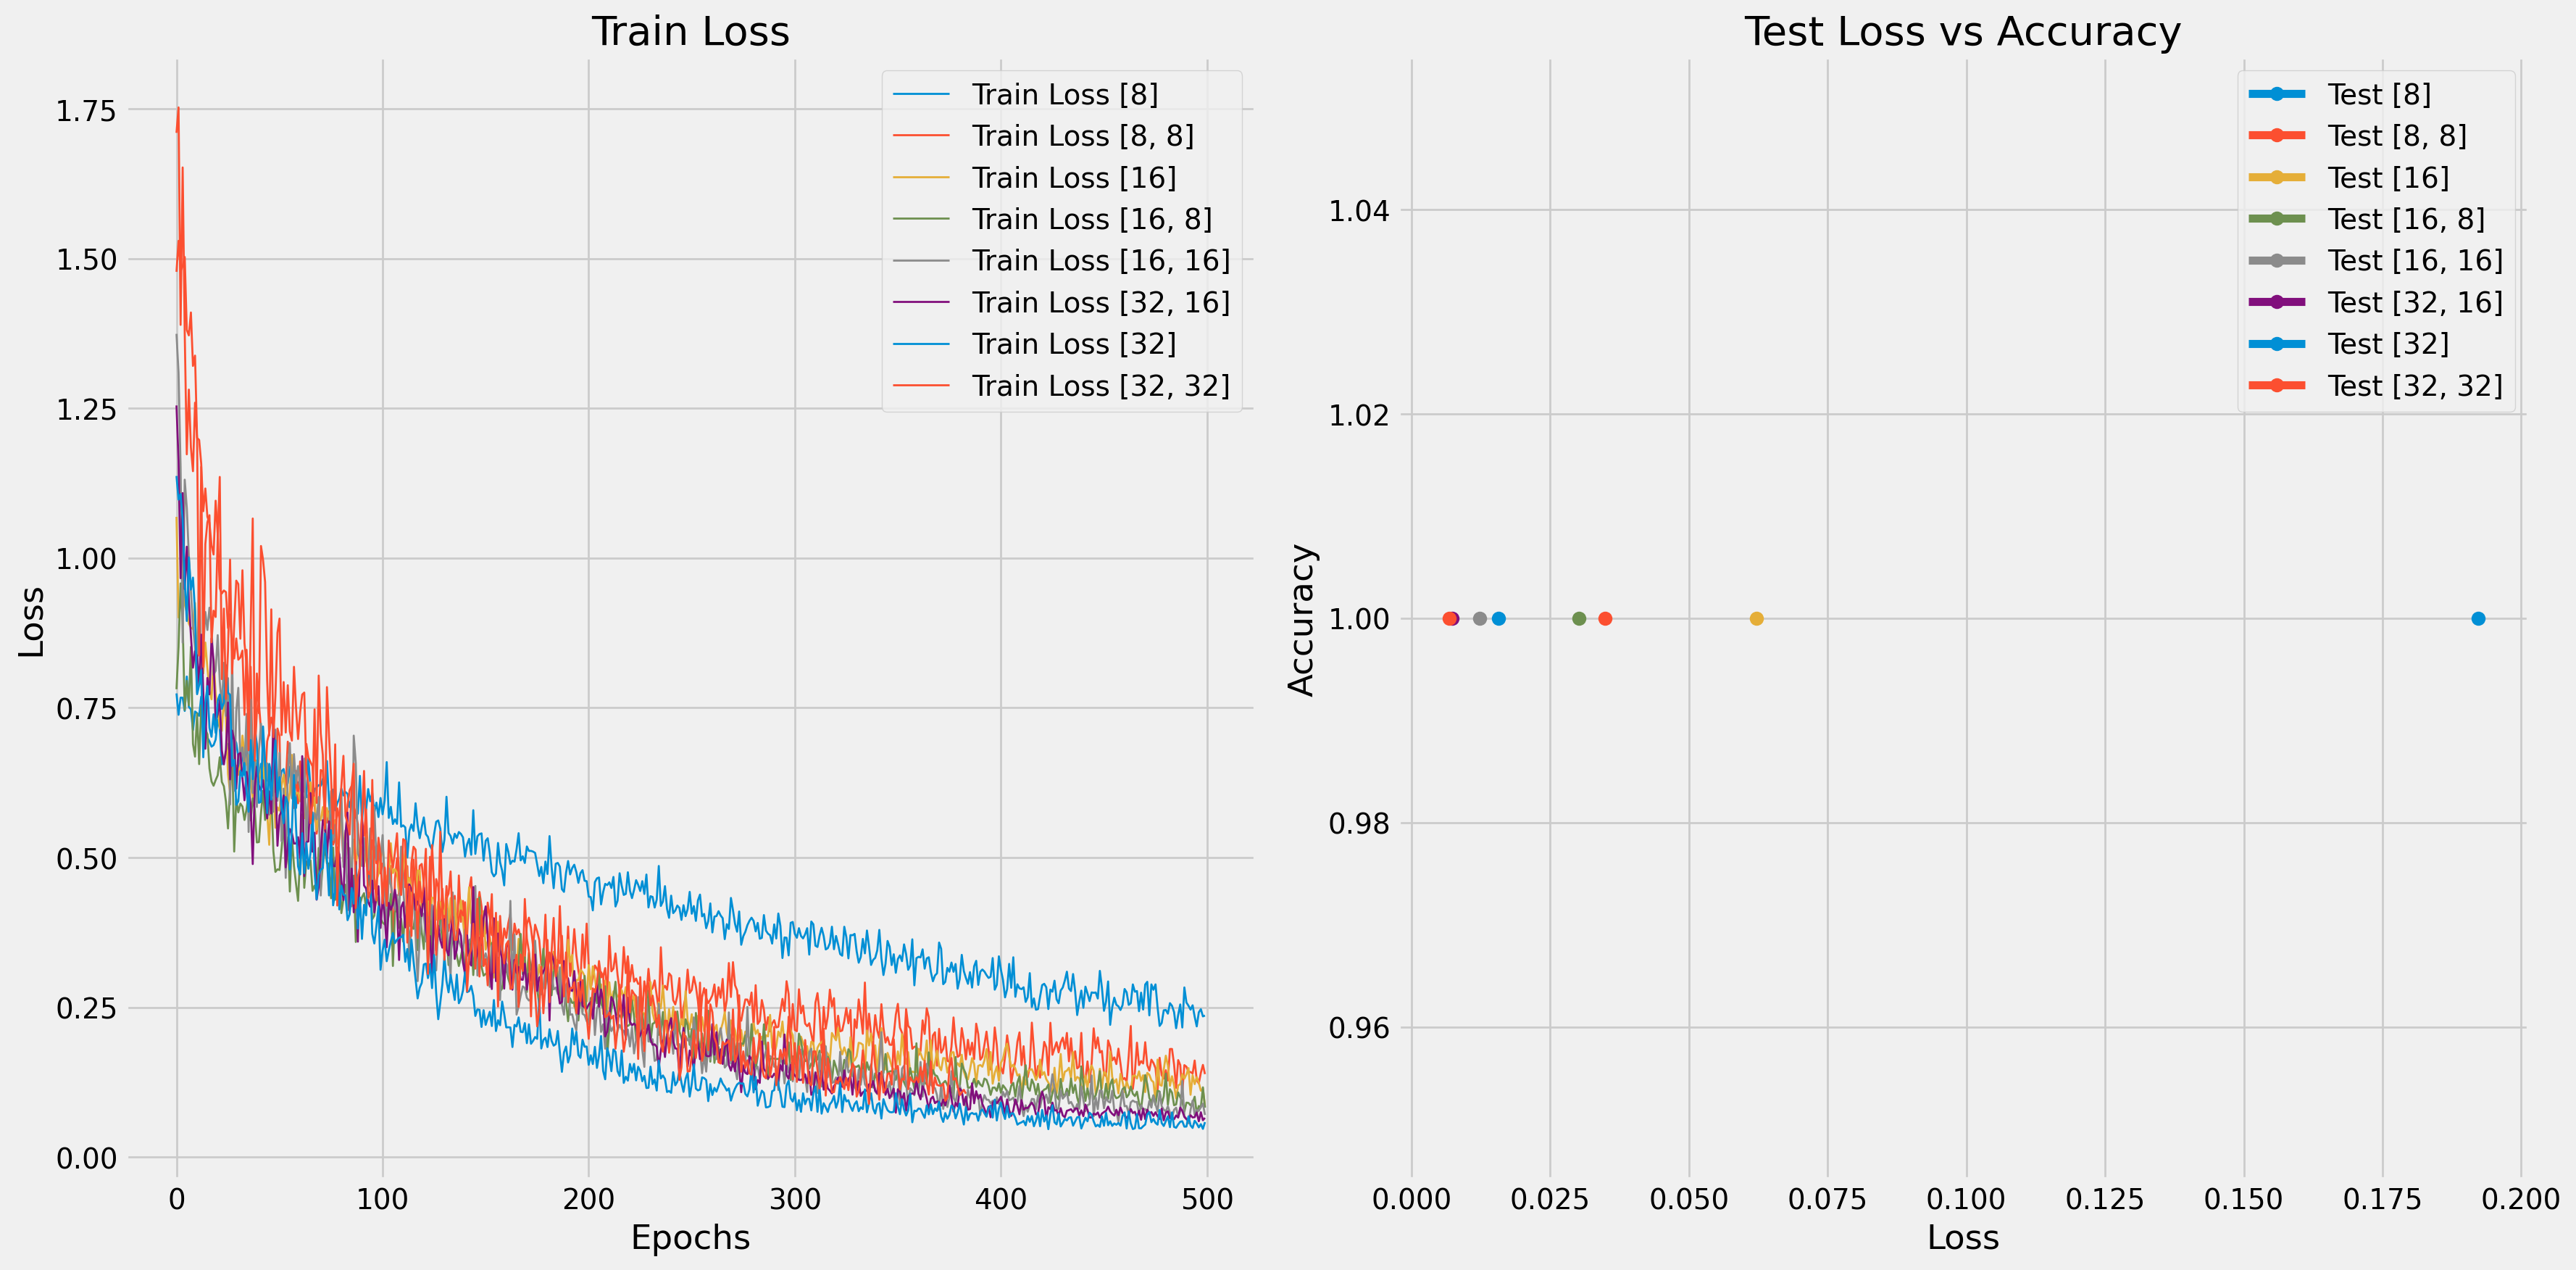

In [10]:
_, ax = plt.subplots(1, 2, figsize=(18, 9))

for i in tqdm.tqdm([
    [8],
    [8, 8],
    [16],
    [16, 8],
    [16, 16],
    [32, 16],
    [32],
    [32, 32],
    ]):
    architecture = [input_features] + i + [output_size]
    model = MLP(architecture, activation='tanh', dropout_p=0.1, use_l2=True)
    criterion = get_loss_function(task=task)
    optimizer = get_optimizer(model, optimizer_type='adam', lr=0.001, momentum=0.01)
    history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        epochs = 500,
        patience = 20,
        l2_lambda = 0.001,
        task = task
    )
    test_loss, test_acc = evaluate_model(
        model, 
        test_loader, 
        criterion, 
        task = task
    )
    ax[0].plot(
        history['train_loss'], 
        label = f'Train Loss {i}',
        linewidth = 1
    )
    ax[1].plot(
        [test_loss],
        [test_acc],
        label = f'Test {i}',
        marker = 'o',
    )
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Train Loss')
    ax[0].legend()
    ax[1].set_xlabel('Loss')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Test Loss vs Accuracy')
    ax[1].legend()
    plt.tight_layout()

### learning rate

 20%|██        | 1/5 [00:00<00:02,  1.79it/s]

early stopping na época 71


 40%|████      | 2/5 [00:01<00:01,  1.88it/s]

early stopping na época 73


 60%|██████    | 3/5 [00:02<00:02,  1.17s/it]

early stopping na época 286


100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


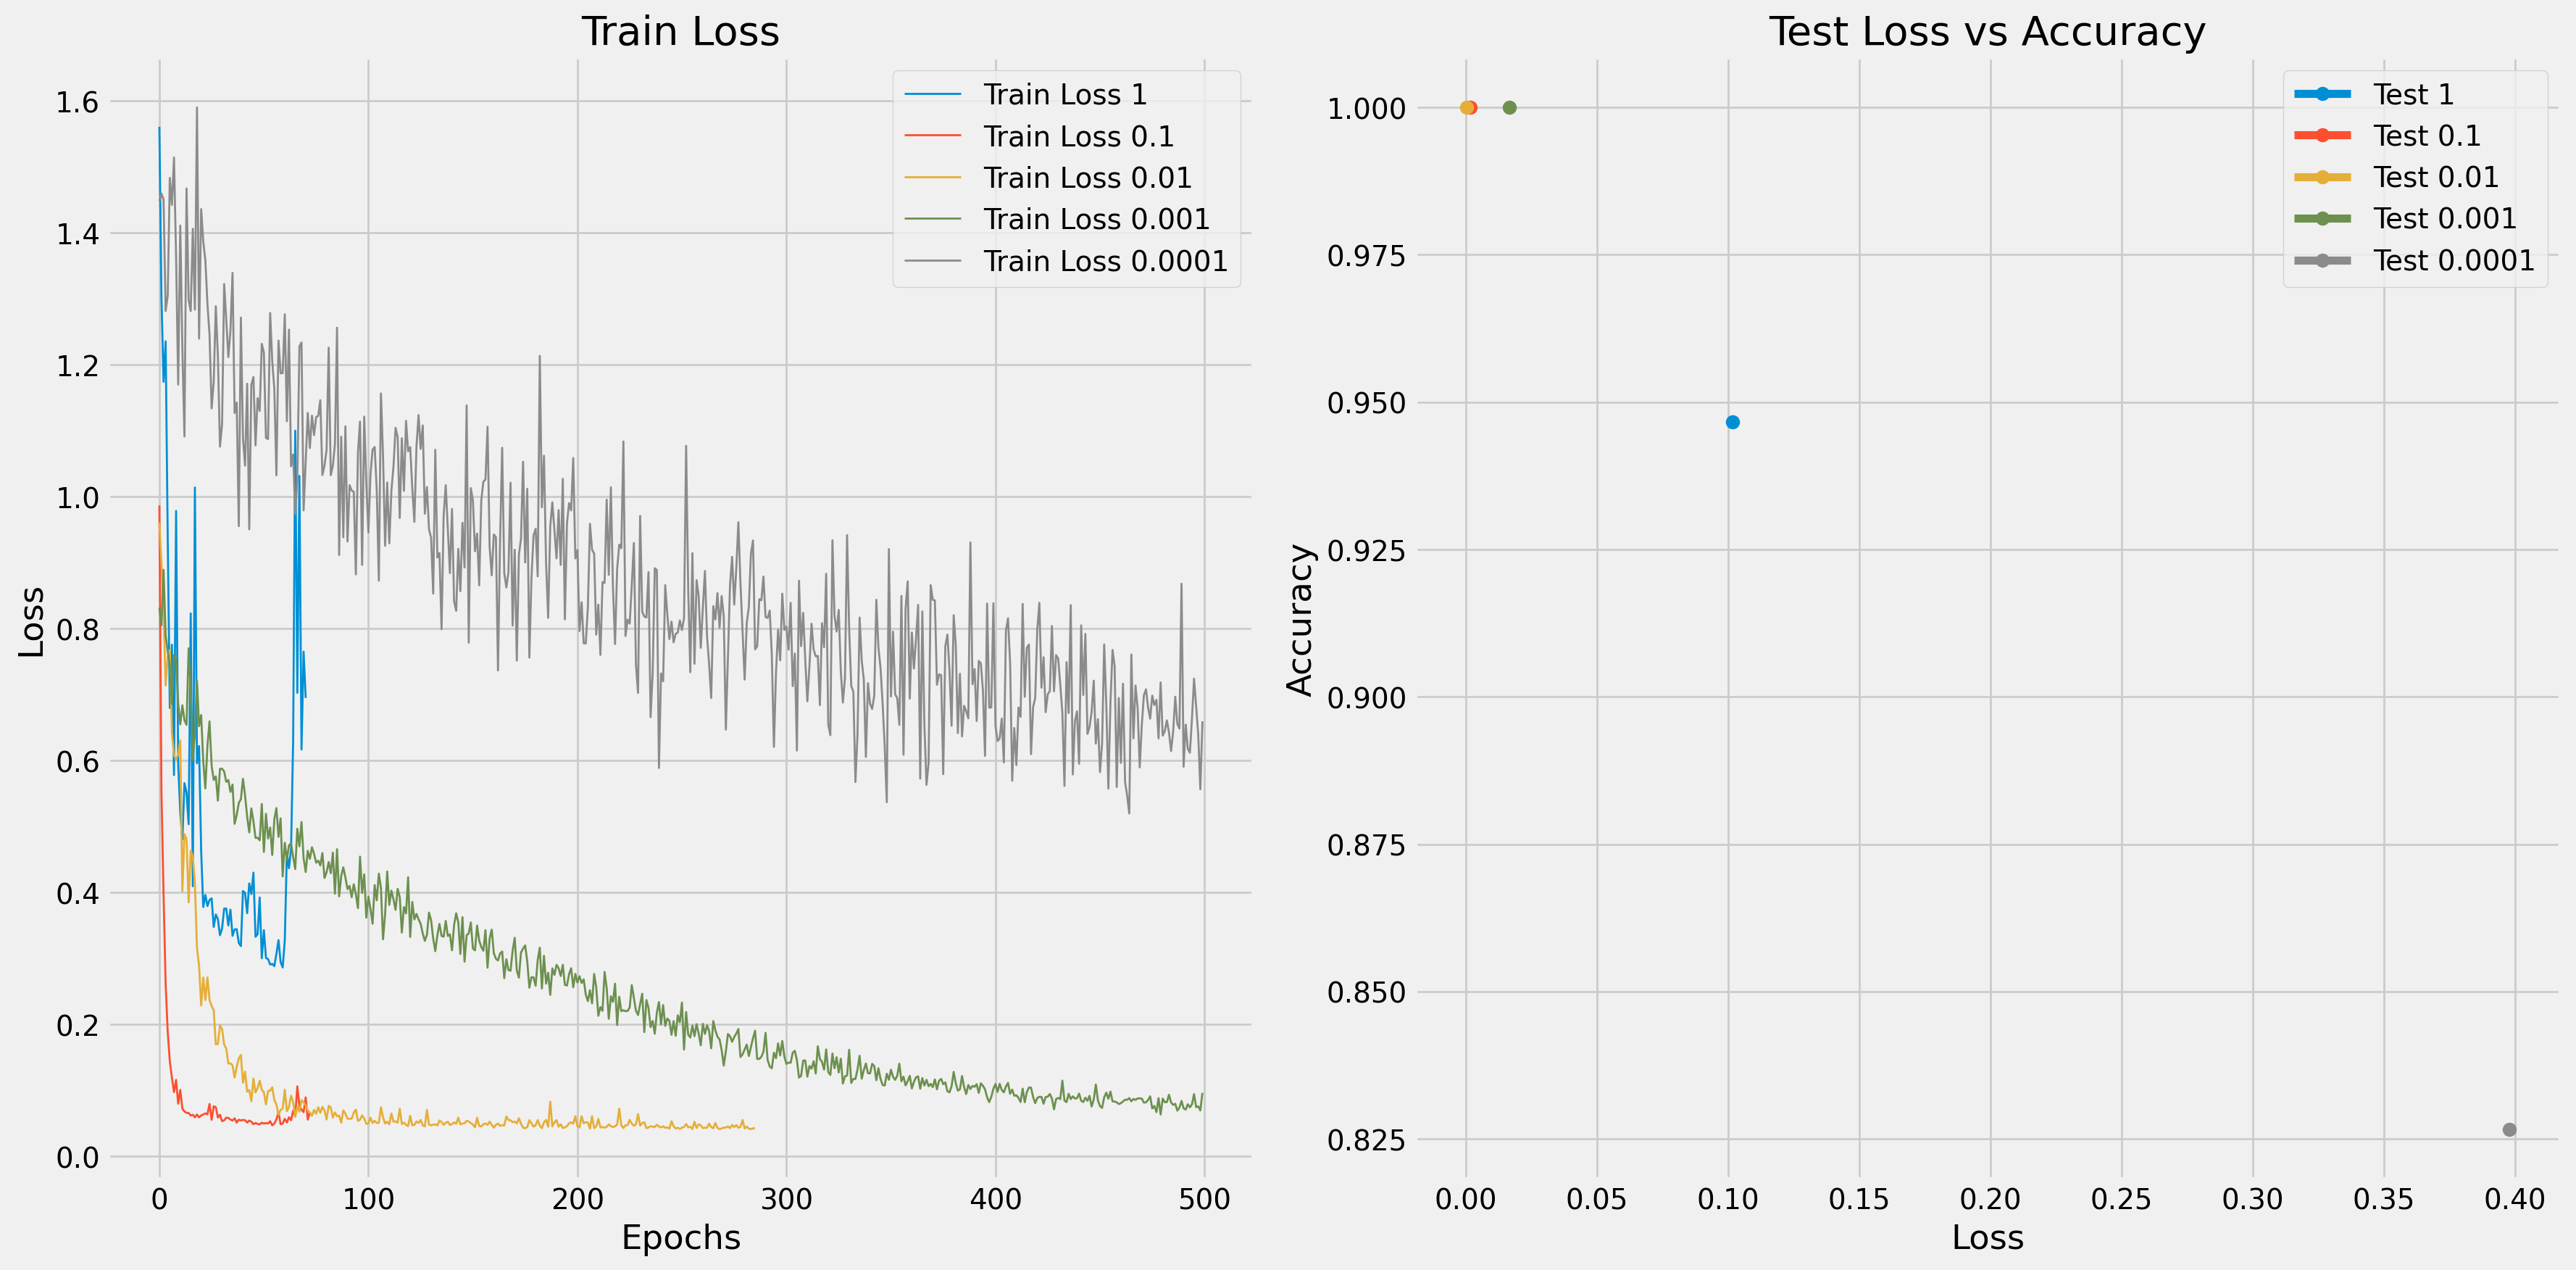

In [11]:
_, ax = plt.subplots(1, 2, figsize=(18, 9))

for i in tqdm.tqdm([1, 1e-1, 1e-2, 1e-3, 1e-4]):
    architecture = [input_features] + [32, 16] + [output_size]
    model = MLP(architecture, activation='tanh', dropout_p=0.1, use_l2=True)
    criterion = get_loss_function(task=task)
    optimizer = get_optimizer(model, optimizer_type='adam', lr=i, momentum=0.01)
    history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        epochs = 500,
        patience = 20,
        l2_lambda = 0.001,
        task = task
    )
    test_loss, test_acc = evaluate_model(
        model, 
        test_loader, 
        criterion, 
        task = task
    )
    ax[0].plot(
        history['train_loss'], 
        label = f'Train Loss {i}',
        linewidth = 1
    )
    ax[1].plot(
        [test_loss],
        [test_acc],
        label = f'Test {i}',
        marker = 'o',
    )
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Train Loss')
    ax[0].legend()
    ax[1].set_xlabel('Loss')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Test Loss vs Accuracy')
    ax[1].legend()
    plt.tight_layout()

### dropout

 20%|██        | 1/5 [00:00<00:01,  3.64it/s]

early stopping na época 21


 40%|████      | 2/5 [00:00<00:00,  3.04it/s]

early stopping na época 48


100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


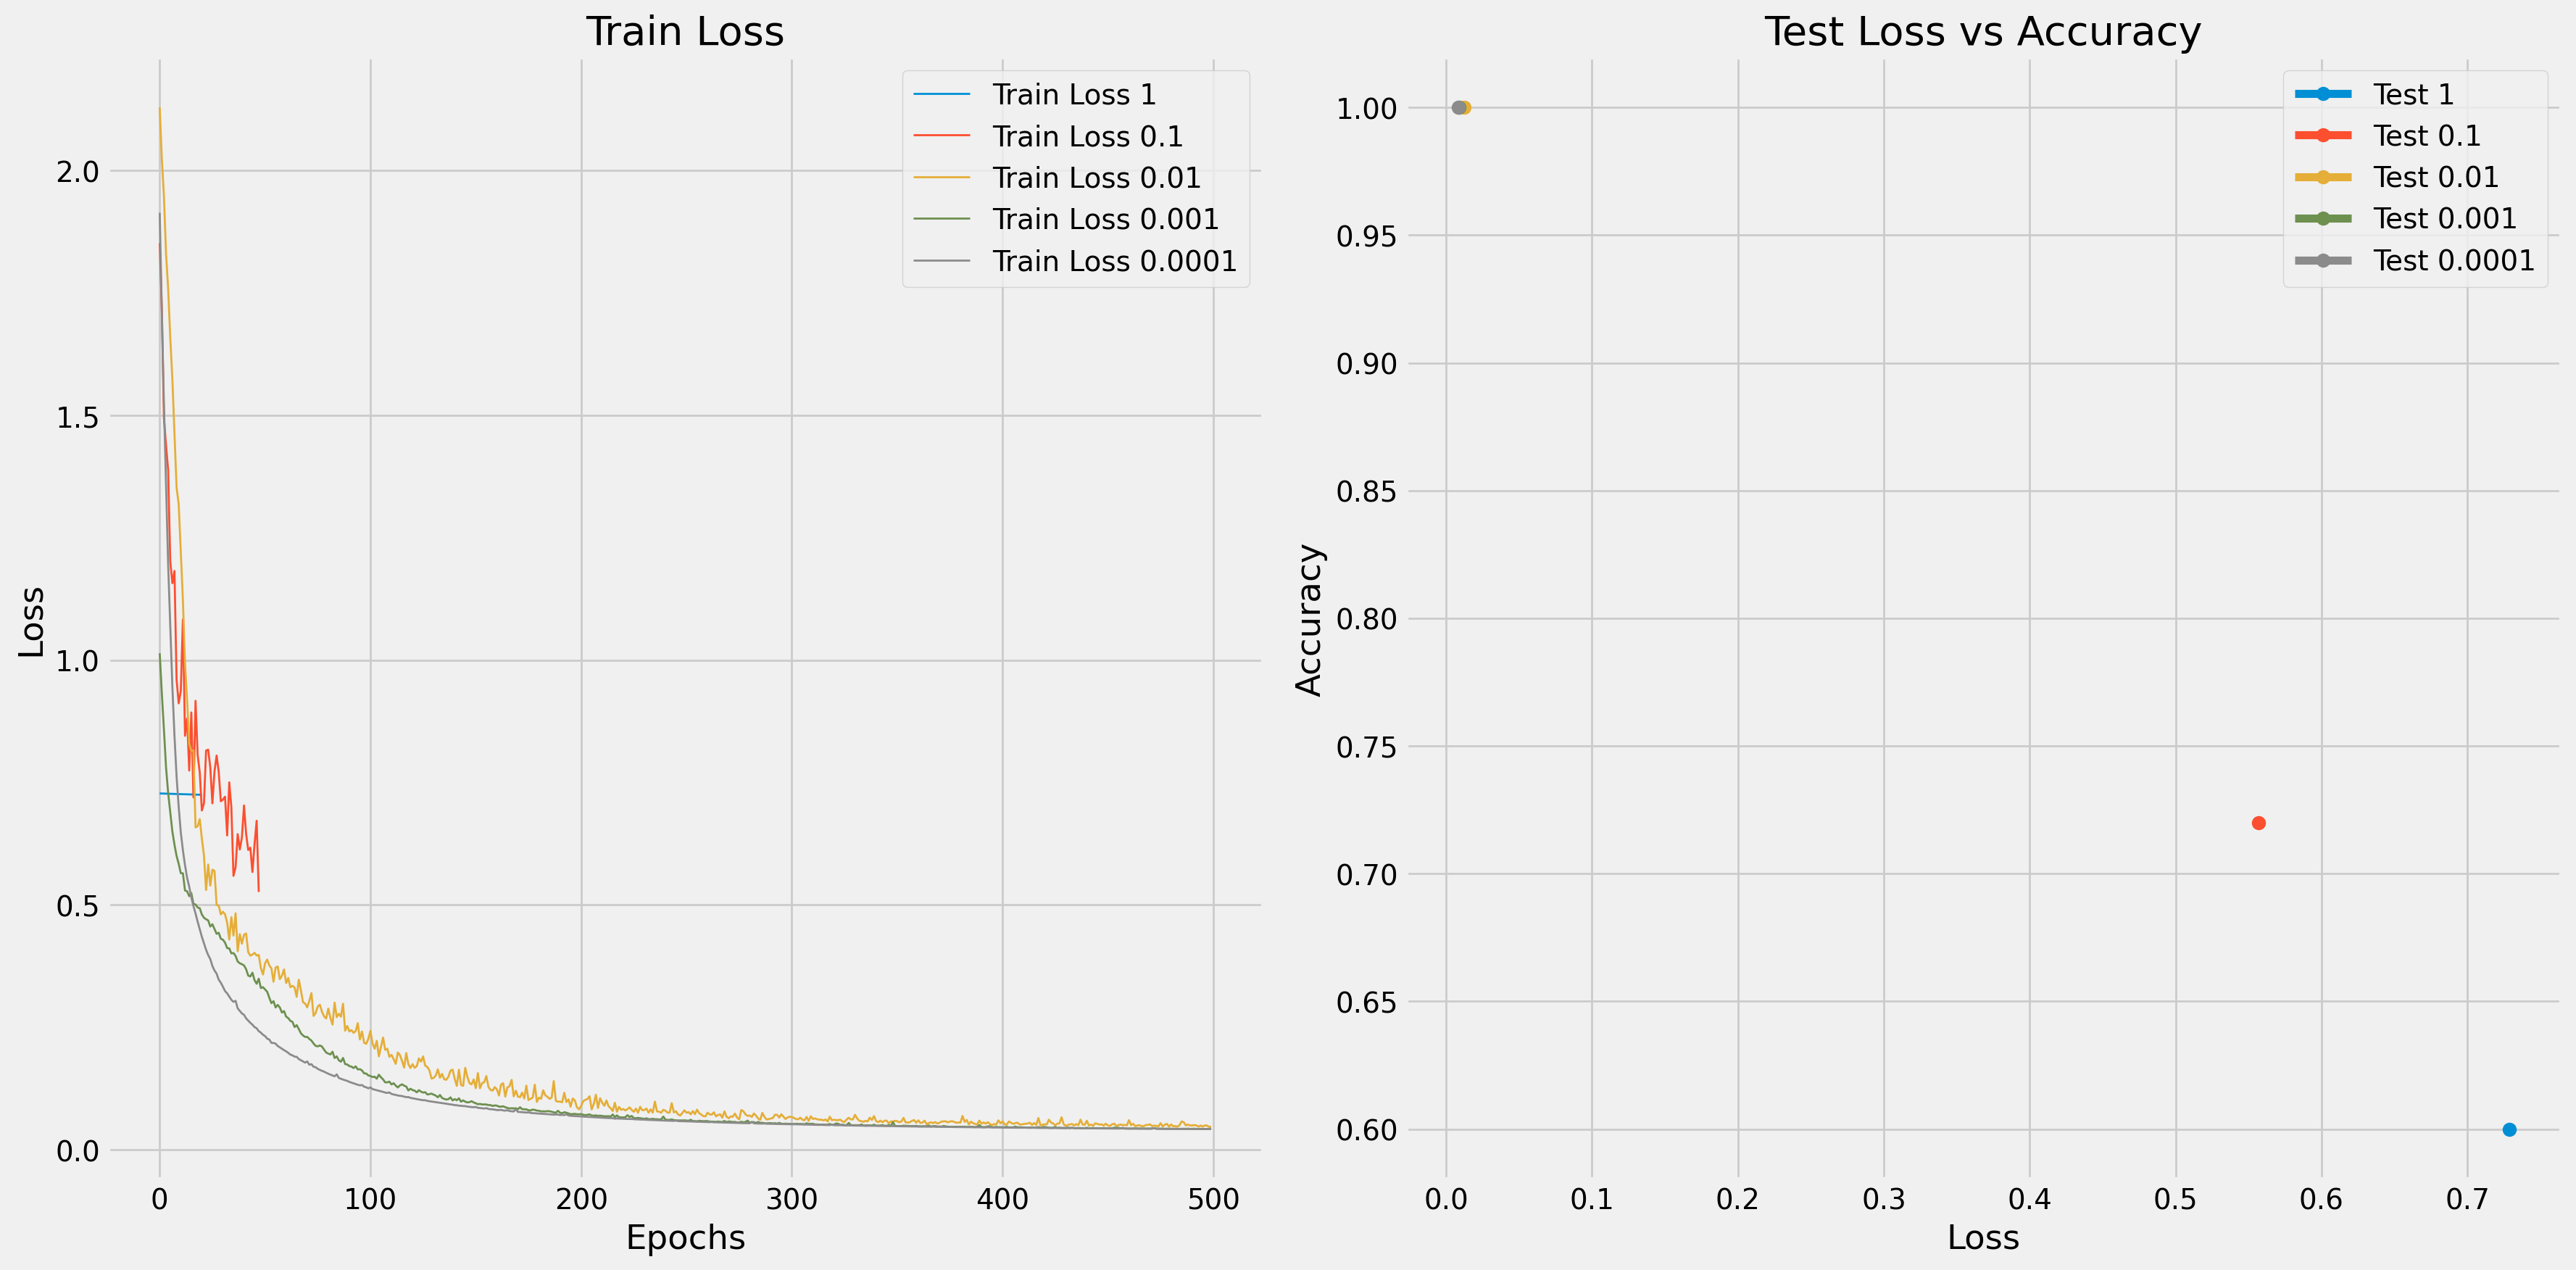

In [12]:
_, ax = plt.subplots(1, 2, figsize=(18, 9))

for i in tqdm.tqdm([1, 1e-1, 1e-2, 1e-3, 1e-4]):
    architecture = [input_features] + [32, 16] + [output_size]
    model = MLP(architecture, activation='tanh', dropout_p=i, use_l2=True)
    criterion = get_loss_function(task=task)
    optimizer = get_optimizer(model, optimizer_type='adam', lr=0.001, momentum=0.01)
    history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        epochs = 500,
        patience = 20,
        l2_lambda = 0.001,
        task = task
    )
    test_loss, test_acc = evaluate_model(
        model, 
        test_loader, 
        criterion, 
        task = task
    )
    ax[0].plot(
        history['train_loss'], 
        label = f'Train Loss {i}',
        linewidth = 1
    )
    ax[1].plot(
        [test_loss],
        [test_acc],
        label = f'Test {i}',
        marker = 'o',
    )
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Train Loss')
    ax[0].legend()
    ax[1].set_xlabel('Loss')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Test Loss vs Accuracy')
    ax[1].legend()
    plt.tight_layout()

### momentum

100%|██████████| 5/5 [00:16<00:00,  3.25s/it]


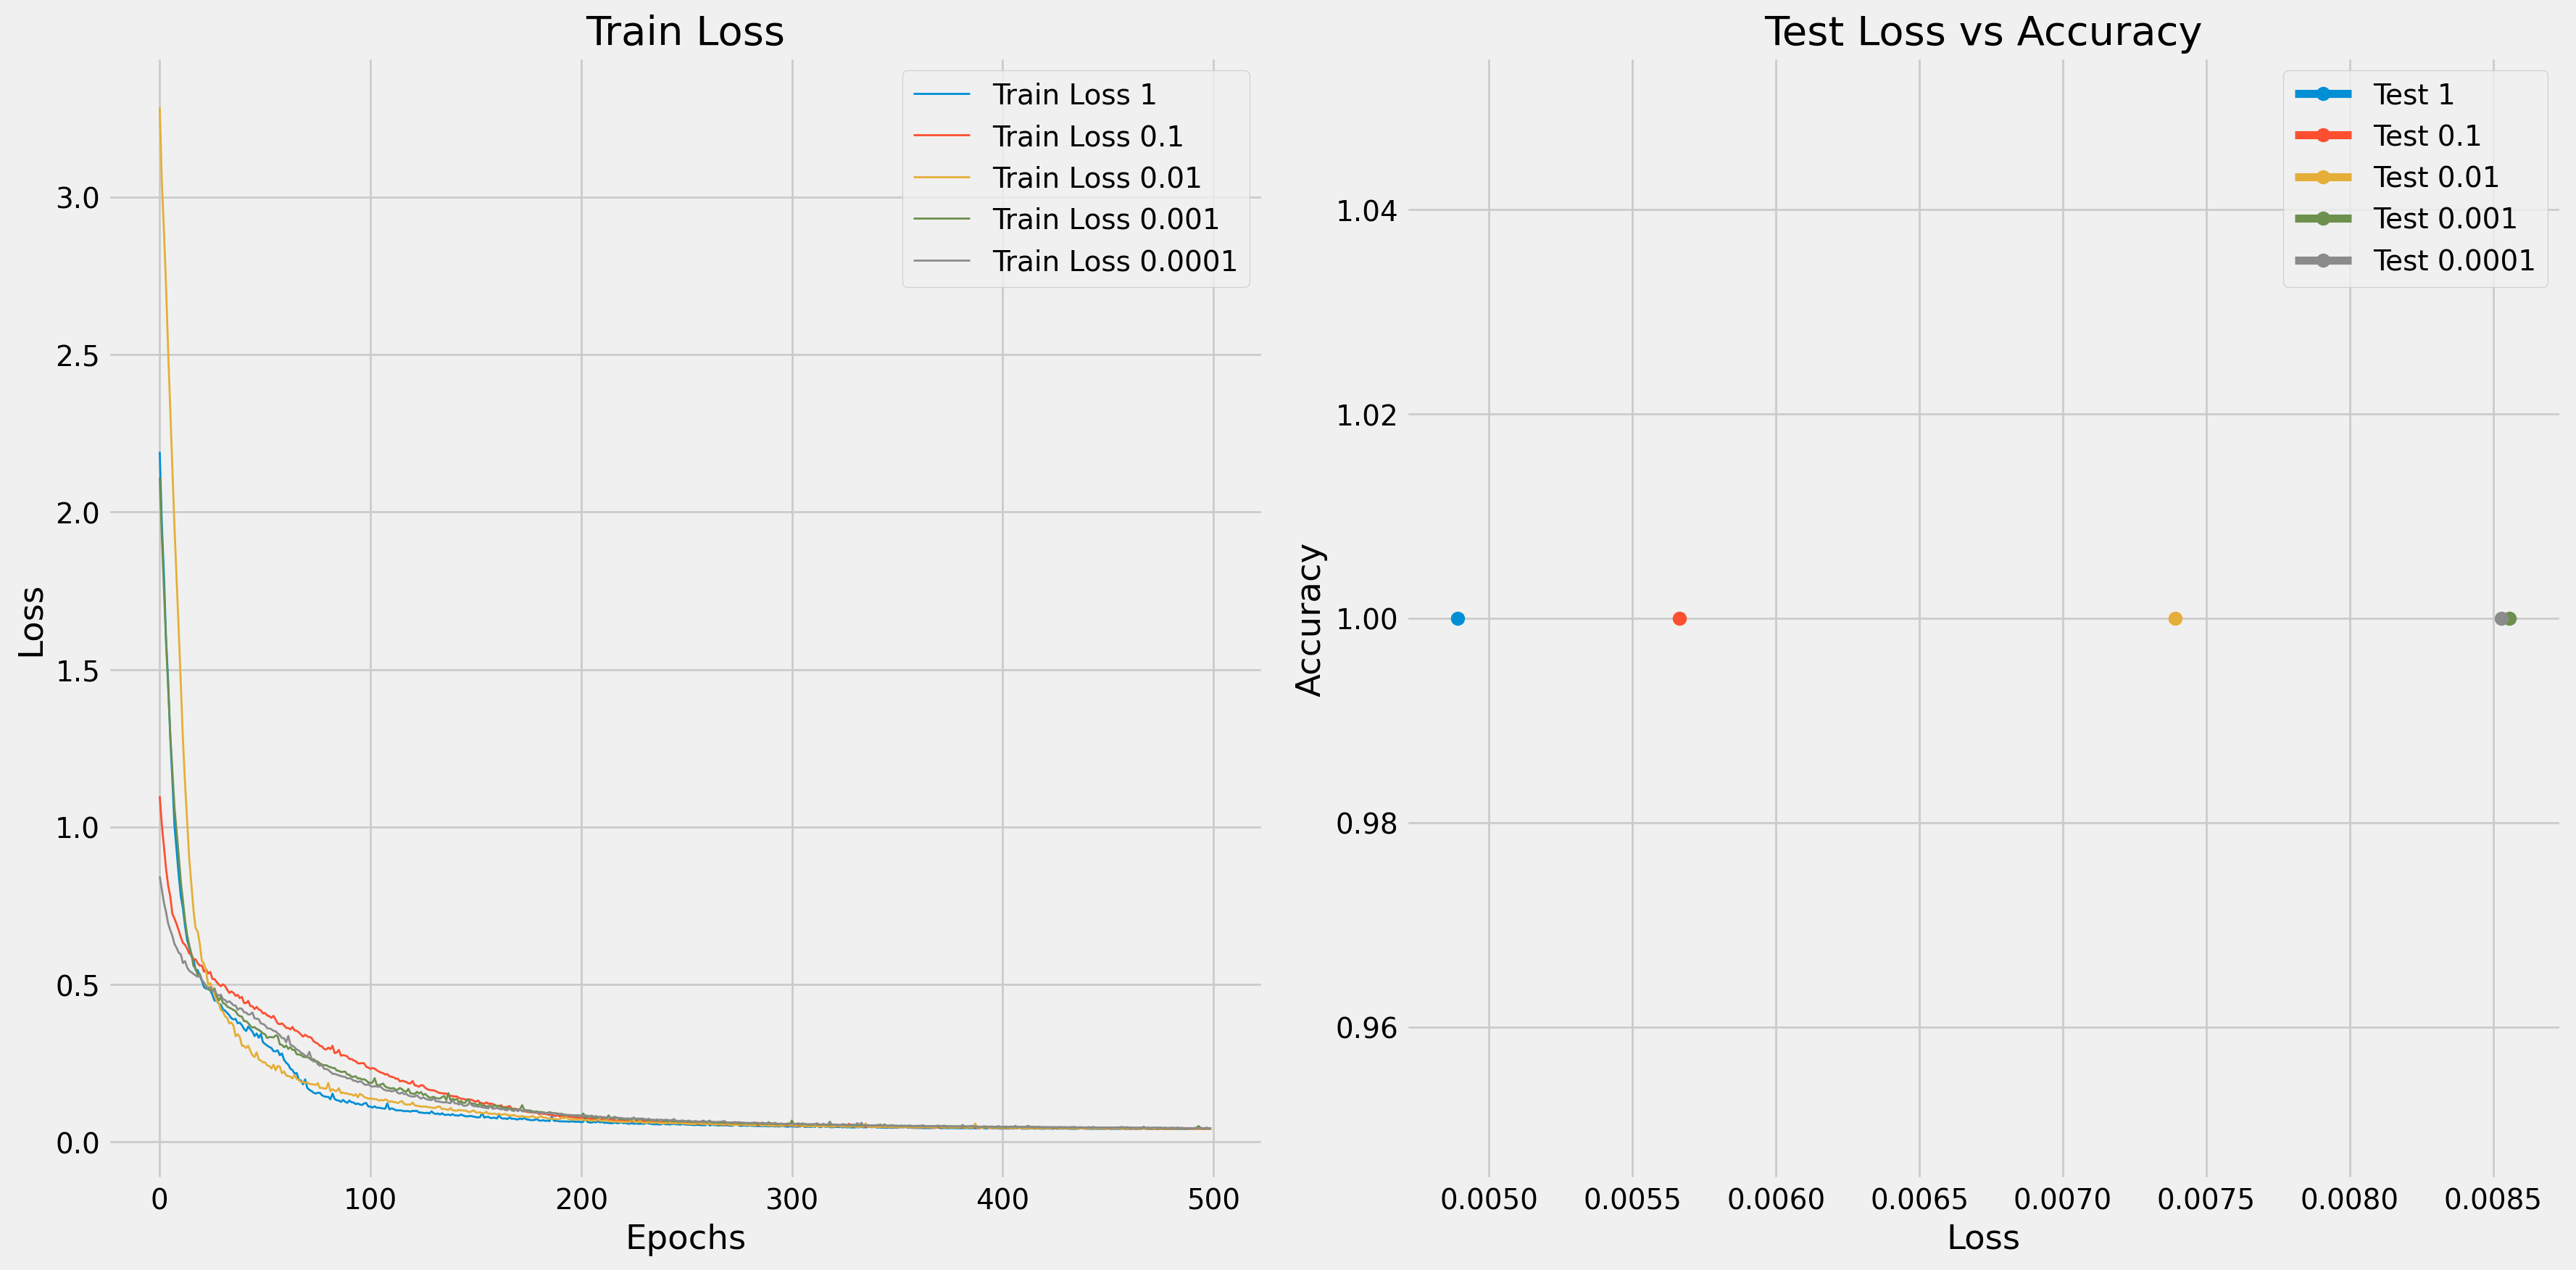

In [13]:
_, ax = plt.subplots(1, 2, figsize=(18, 9))

for i in tqdm.tqdm([1, 1e-1, 1e-2, 1e-3, 1e-4]):
    architecture = [input_features] + [32, 16] + [output_size]
    model = MLP(architecture, activation='tanh', dropout_p=0.001, use_l2=True)
    criterion = get_loss_function(task=task)
    optimizer = get_optimizer(model, optimizer_type='adam', lr=0.001, momentum=i)
    history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        epochs = 500,
        patience = 20,
        l2_lambda = 0.001,
        task = task
    )
    test_loss, test_acc = evaluate_model(
        model, 
        test_loader, 
        criterion, 
        task = task
    )
    ax[0].plot(
        history['train_loss'], 
        label = f'Train Loss {i}',
        linewidth = 1
    )
    ax[1].plot(
        [test_loss],
        [test_acc],
        label = f'Test {i}',
        marker = 'o',
    )
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Train Loss')
    ax[0].legend()
    ax[1].set_xlabel('Loss')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Test Loss vs Accuracy')
    ax[1].legend()
    plt.tight_layout()

### regularization

 20%|██        | 1/5 [00:00<00:03,  1.18it/s]

early stopping na época 118


 40%|████      | 2/5 [00:01<00:02,  1.00it/s]

early stopping na época 168


 60%|██████    | 3/5 [00:04<00:03,  1.60s/it]

early stopping na época 340


 80%|████████  | 4/5 [00:07<00:02,  2.08s/it]

early stopping na época 409


100%|██████████| 5/5 [00:10<00:00,  2.05s/it]

early stopping na época 477


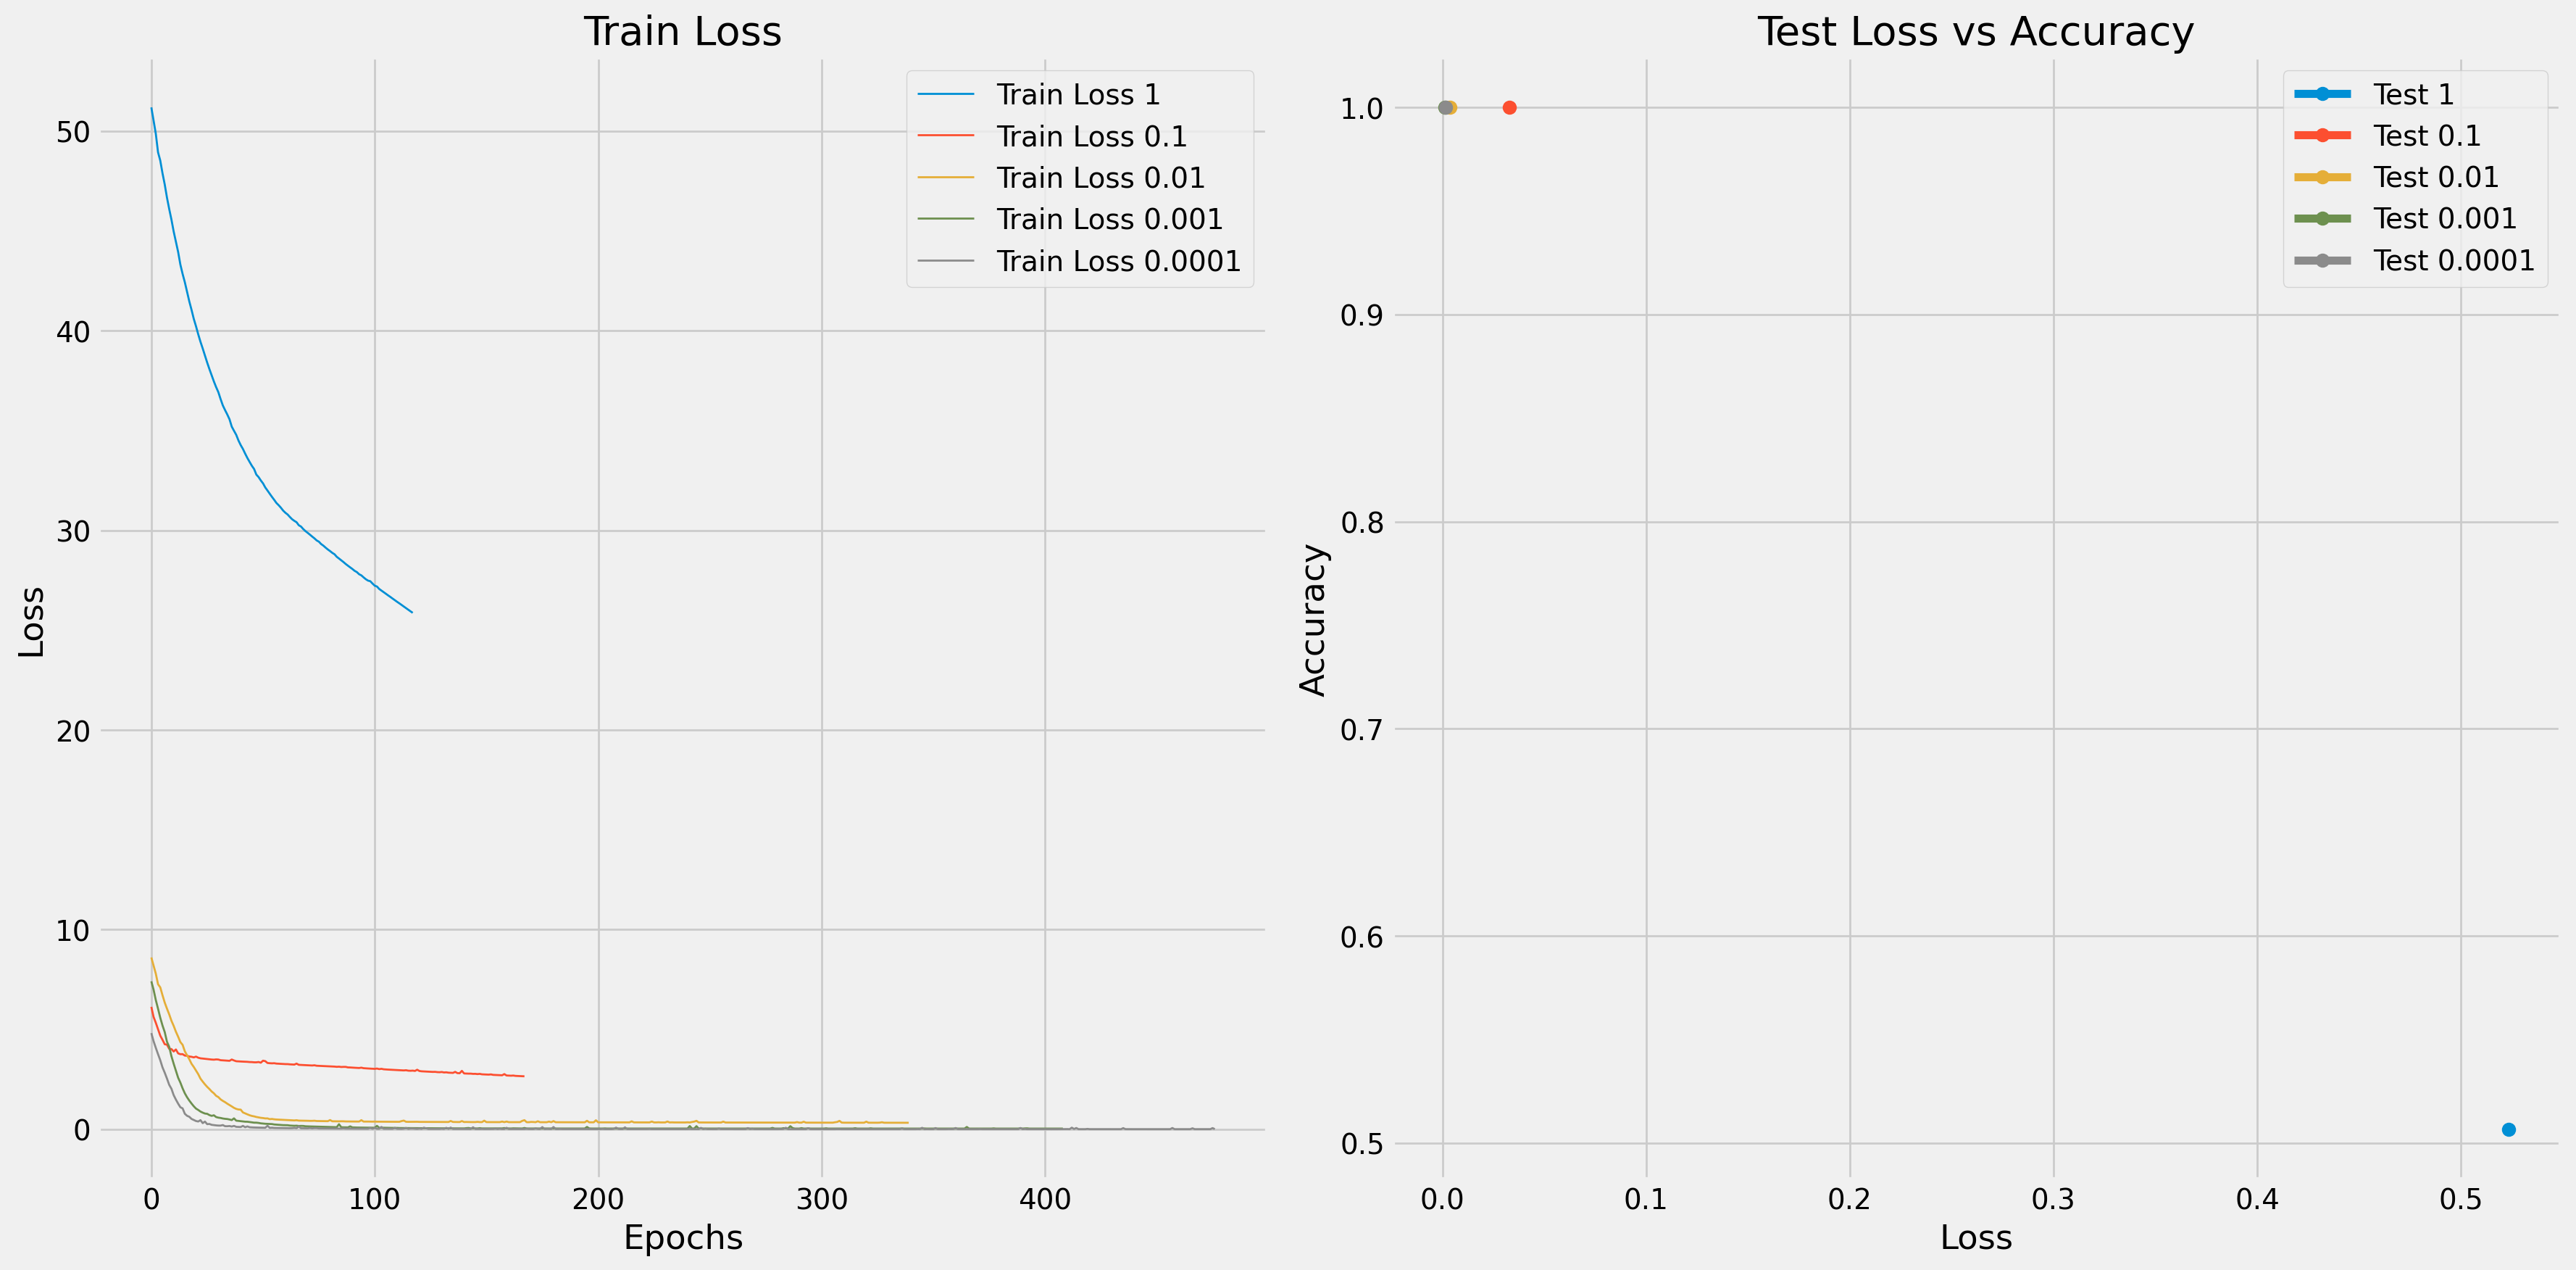

In [14]:
_, ax = plt.subplots(1, 2, figsize=(18, 9))

for i in tqdm.tqdm([1, 1e-1, 1e-2, 1e-3, 1e-4]):
    architecture = [input_features] + [32, 16] + [output_size]
    model = MLP(architecture, activation='relu', dropout_p=0.001, use_l2=True)
    criterion = get_loss_function(task=task)
    optimizer = get_optimizer(model, optimizer_type='adam', lr=0.001, momentum=0.001)
    history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        epochs = 500,
        patience = 20,
        l2_lambda = i,
        task = task
    )
    test_loss, test_acc = evaluate_model(
        model, 
        test_loader, 
        criterion, 
        task = task
    )
    ax[0].plot(
        history['train_loss'], 
        label = f'Train Loss {i}',
        linewidth = 1
    )
    ax[1].plot(
        [test_loss],
        [test_acc],
        label = f'Test {i}',
        marker = 'o',
    )
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Train Loss')
    ax[0].legend()
    ax[1].set_xlabel('Loss')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Test Loss vs Accuracy')
    ax[1].legend()
    plt.tight_layout()

### activation

100%|██████████| 2/2 [00:05<00:00,  2.67s/it]

early stopping na época 312


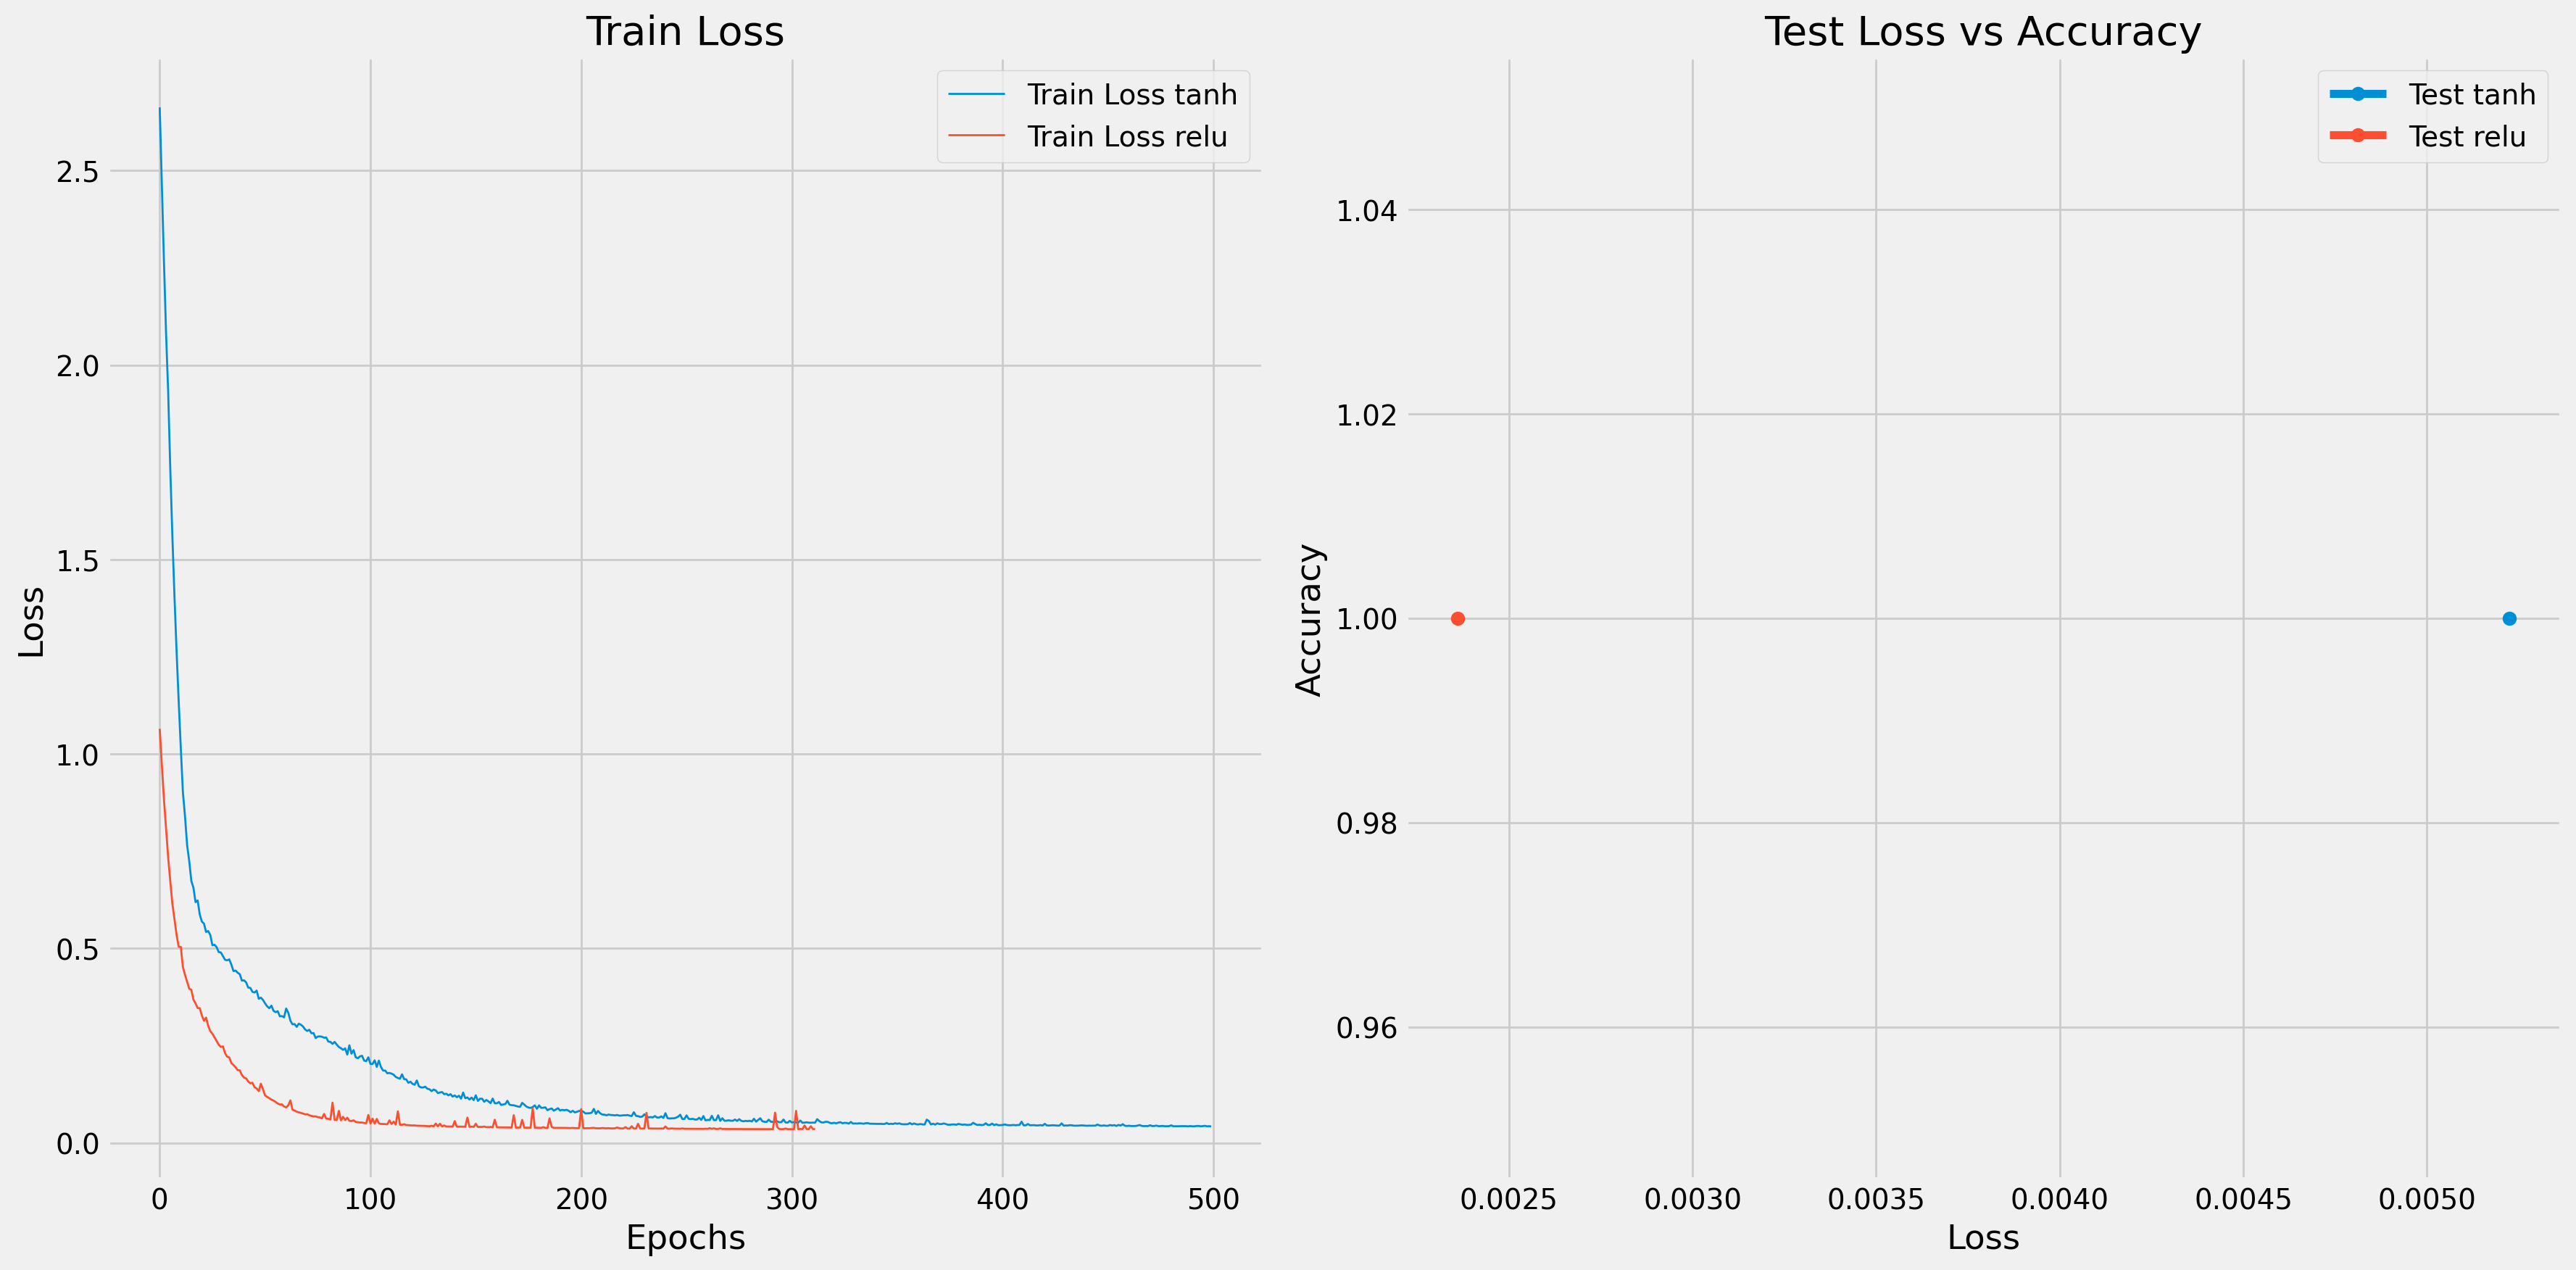

In [15]:
_, ax = plt.subplots(1, 2, figsize=(18, 9))

for i in tqdm.tqdm(['tanh', 'relu']):
    architecture = [input_features] + [32, 16] + [output_size]
    model = MLP(architecture, activation=i, dropout_p=0.001, use_l2=True)
    criterion = get_loss_function(task=task)
    optimizer = get_optimizer(model, optimizer_type='adam', lr=0.001, momentum=0.001)
    history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        epochs = 500,
        patience = 20,
        l2_lambda = 0.001,
        task = task
    )
    test_loss, test_acc = evaluate_model(
        model, 
        test_loader, 
        criterion, 
        task = task
    )
    ax[0].plot(
        history['train_loss'], 
        label = f'Train Loss {i}',
        linewidth = 1
    )
    ax[1].plot(
        [test_loss],
        [test_acc],
        label = f'Test {i}',
        marker = 'o',
    )
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Train Loss')
    ax[0].legend()
    ax[1].set_xlabel('Loss')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Test Loss vs Accuracy')
    ax[1].legend()
    plt.tight_layout()

### optimizer

100%|██████████| 2/2 [00:06<00:00,  3.01s/it]


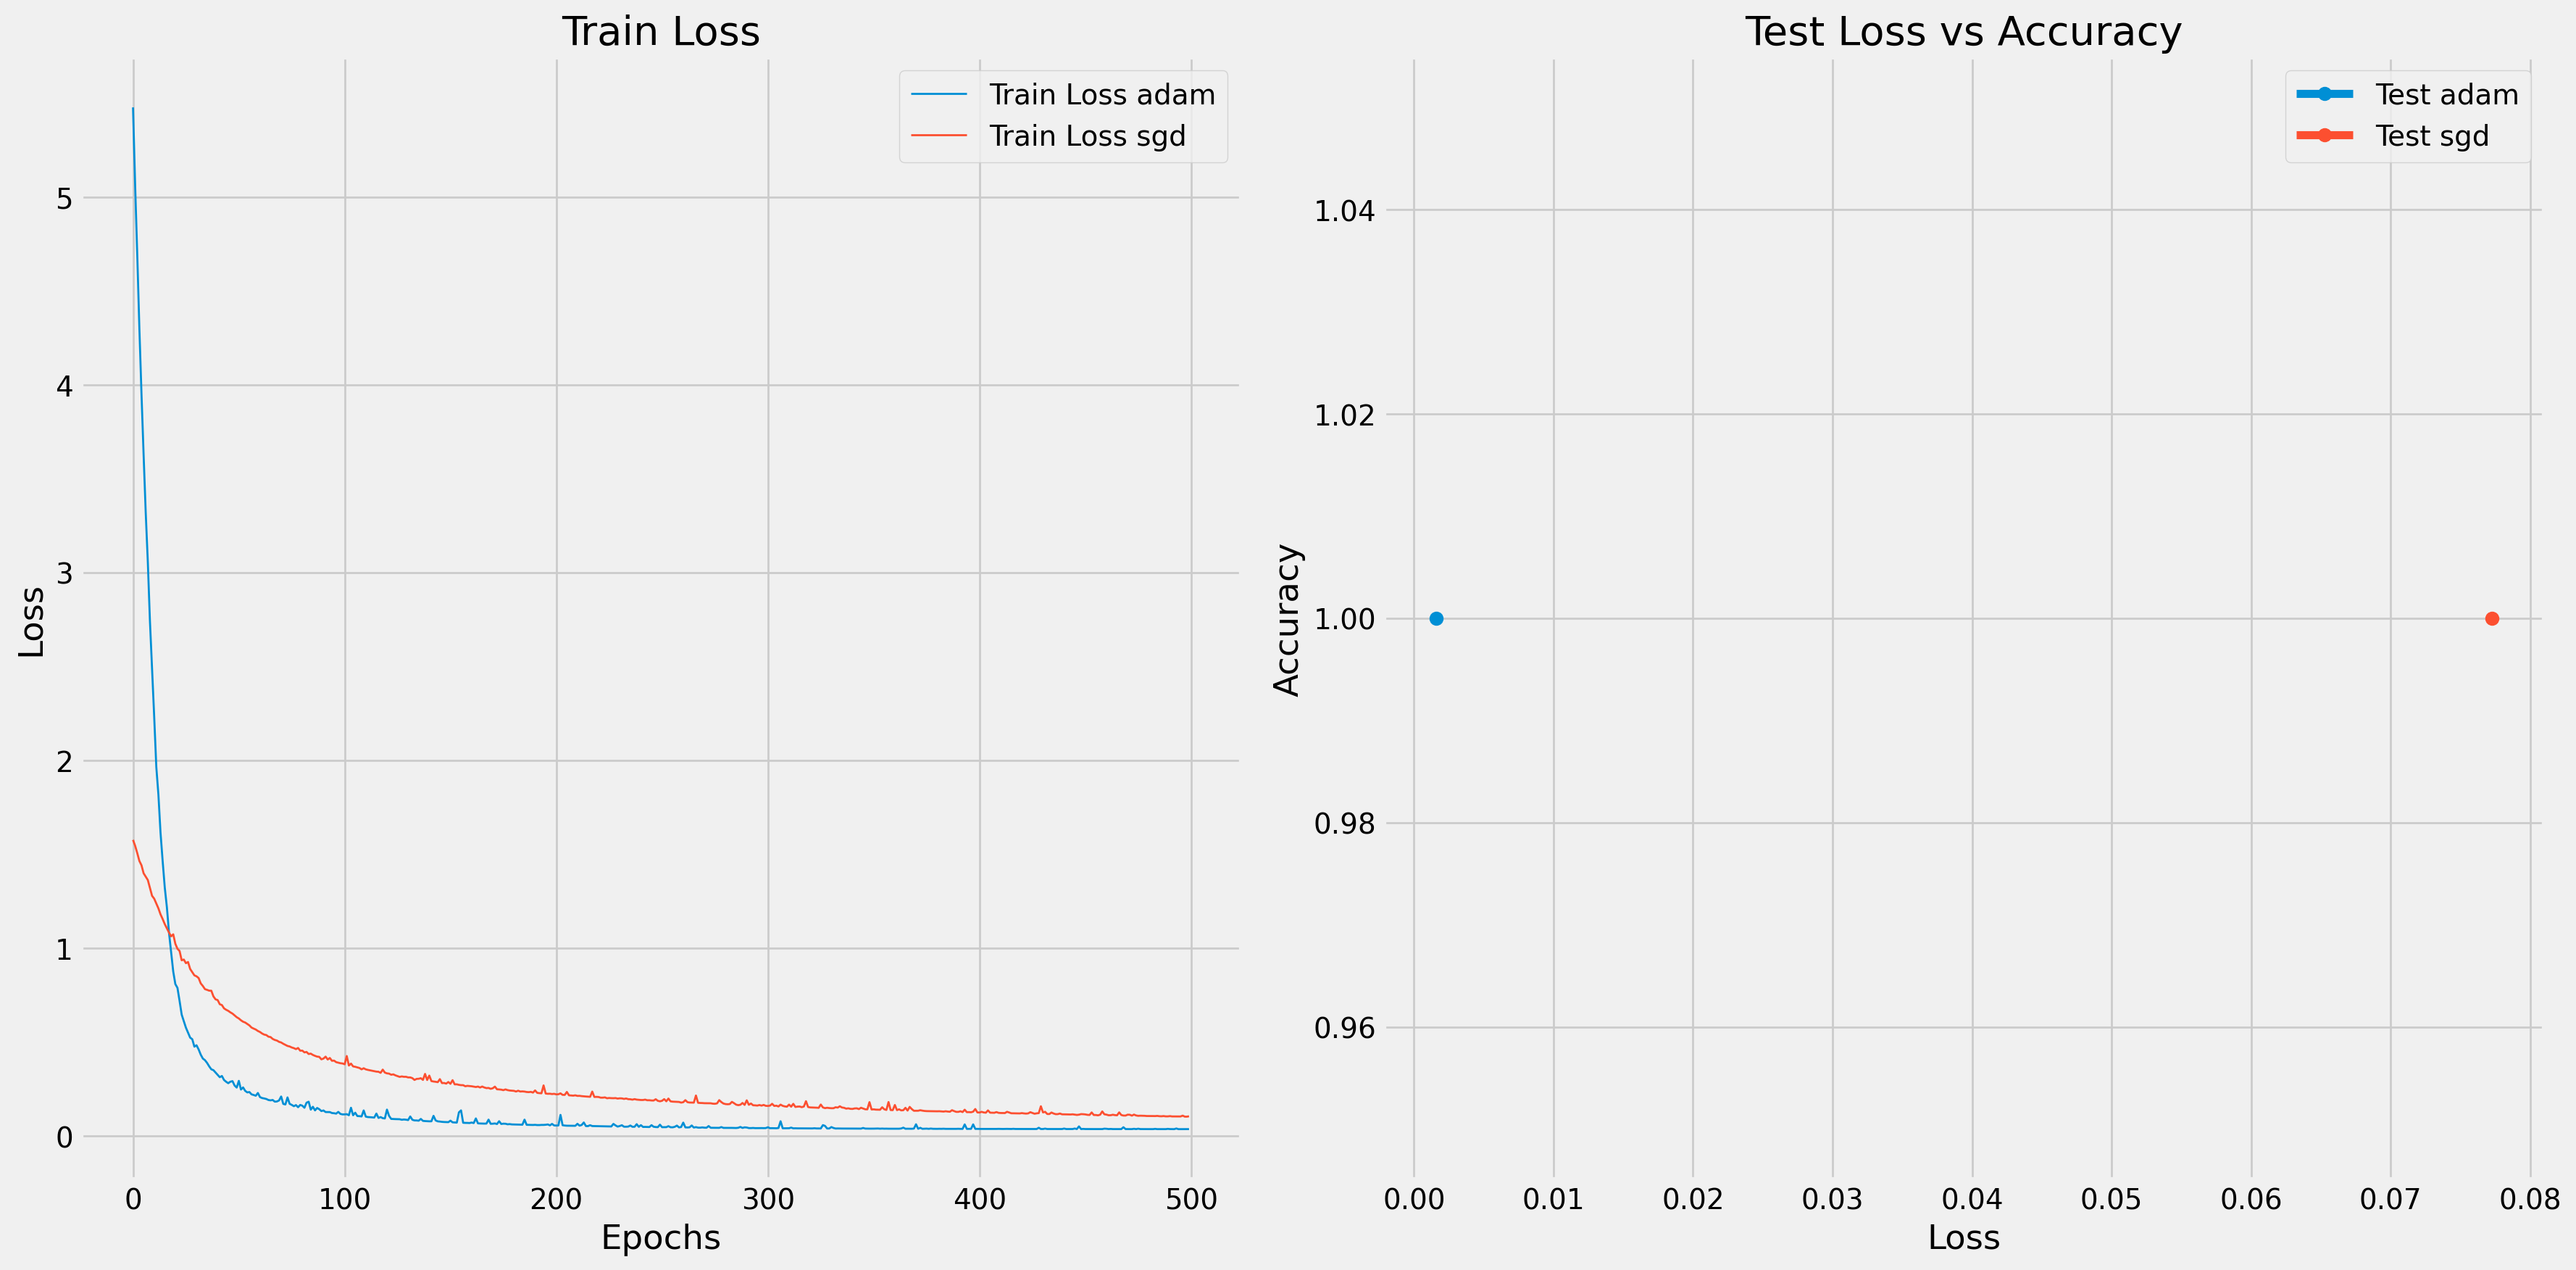

In [16]:
_, ax = plt.subplots(1, 2, figsize=(18, 9))

for i in tqdm.tqdm(['adam', 'sgd']):
    architecture = [input_features] + [32, 16] + [output_size]
    model = MLP(architecture, activation='relu', dropout_p=0.001, use_l2=True)
    criterion = get_loss_function(task=task)
    optimizer = get_optimizer(model, optimizer_type=i, lr=0.001, momentum=0.001)
    history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        epochs = 500,
        patience = 20,
        l2_lambda = 0.001,
        task = task
    )
    test_loss, test_acc = evaluate_model(
        model, 
        test_loader, 
        criterion, 
        task = task
    )
    ax[0].plot(
        history['train_loss'], 
        label = f'Train Loss {i}',
        linewidth = 1
    )
    ax[1].plot(
        [test_loss],
        [test_acc],
        label = f'Test {i}',
        marker = 'o',
    )
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Train Loss')
    ax[0].legend()
    ax[1].set_xlabel('Loss')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Test Loss vs Accuracy')
    ax[1].legend()
    plt.tight_layout()

proposta de arquitetura e hiperparâmetros:
* camadas ocultas 32 -> 16
* relu
* dropout 0.01
* learning rate 0.001
* momentum 0.1
* l2 0.001
* épocas 100500

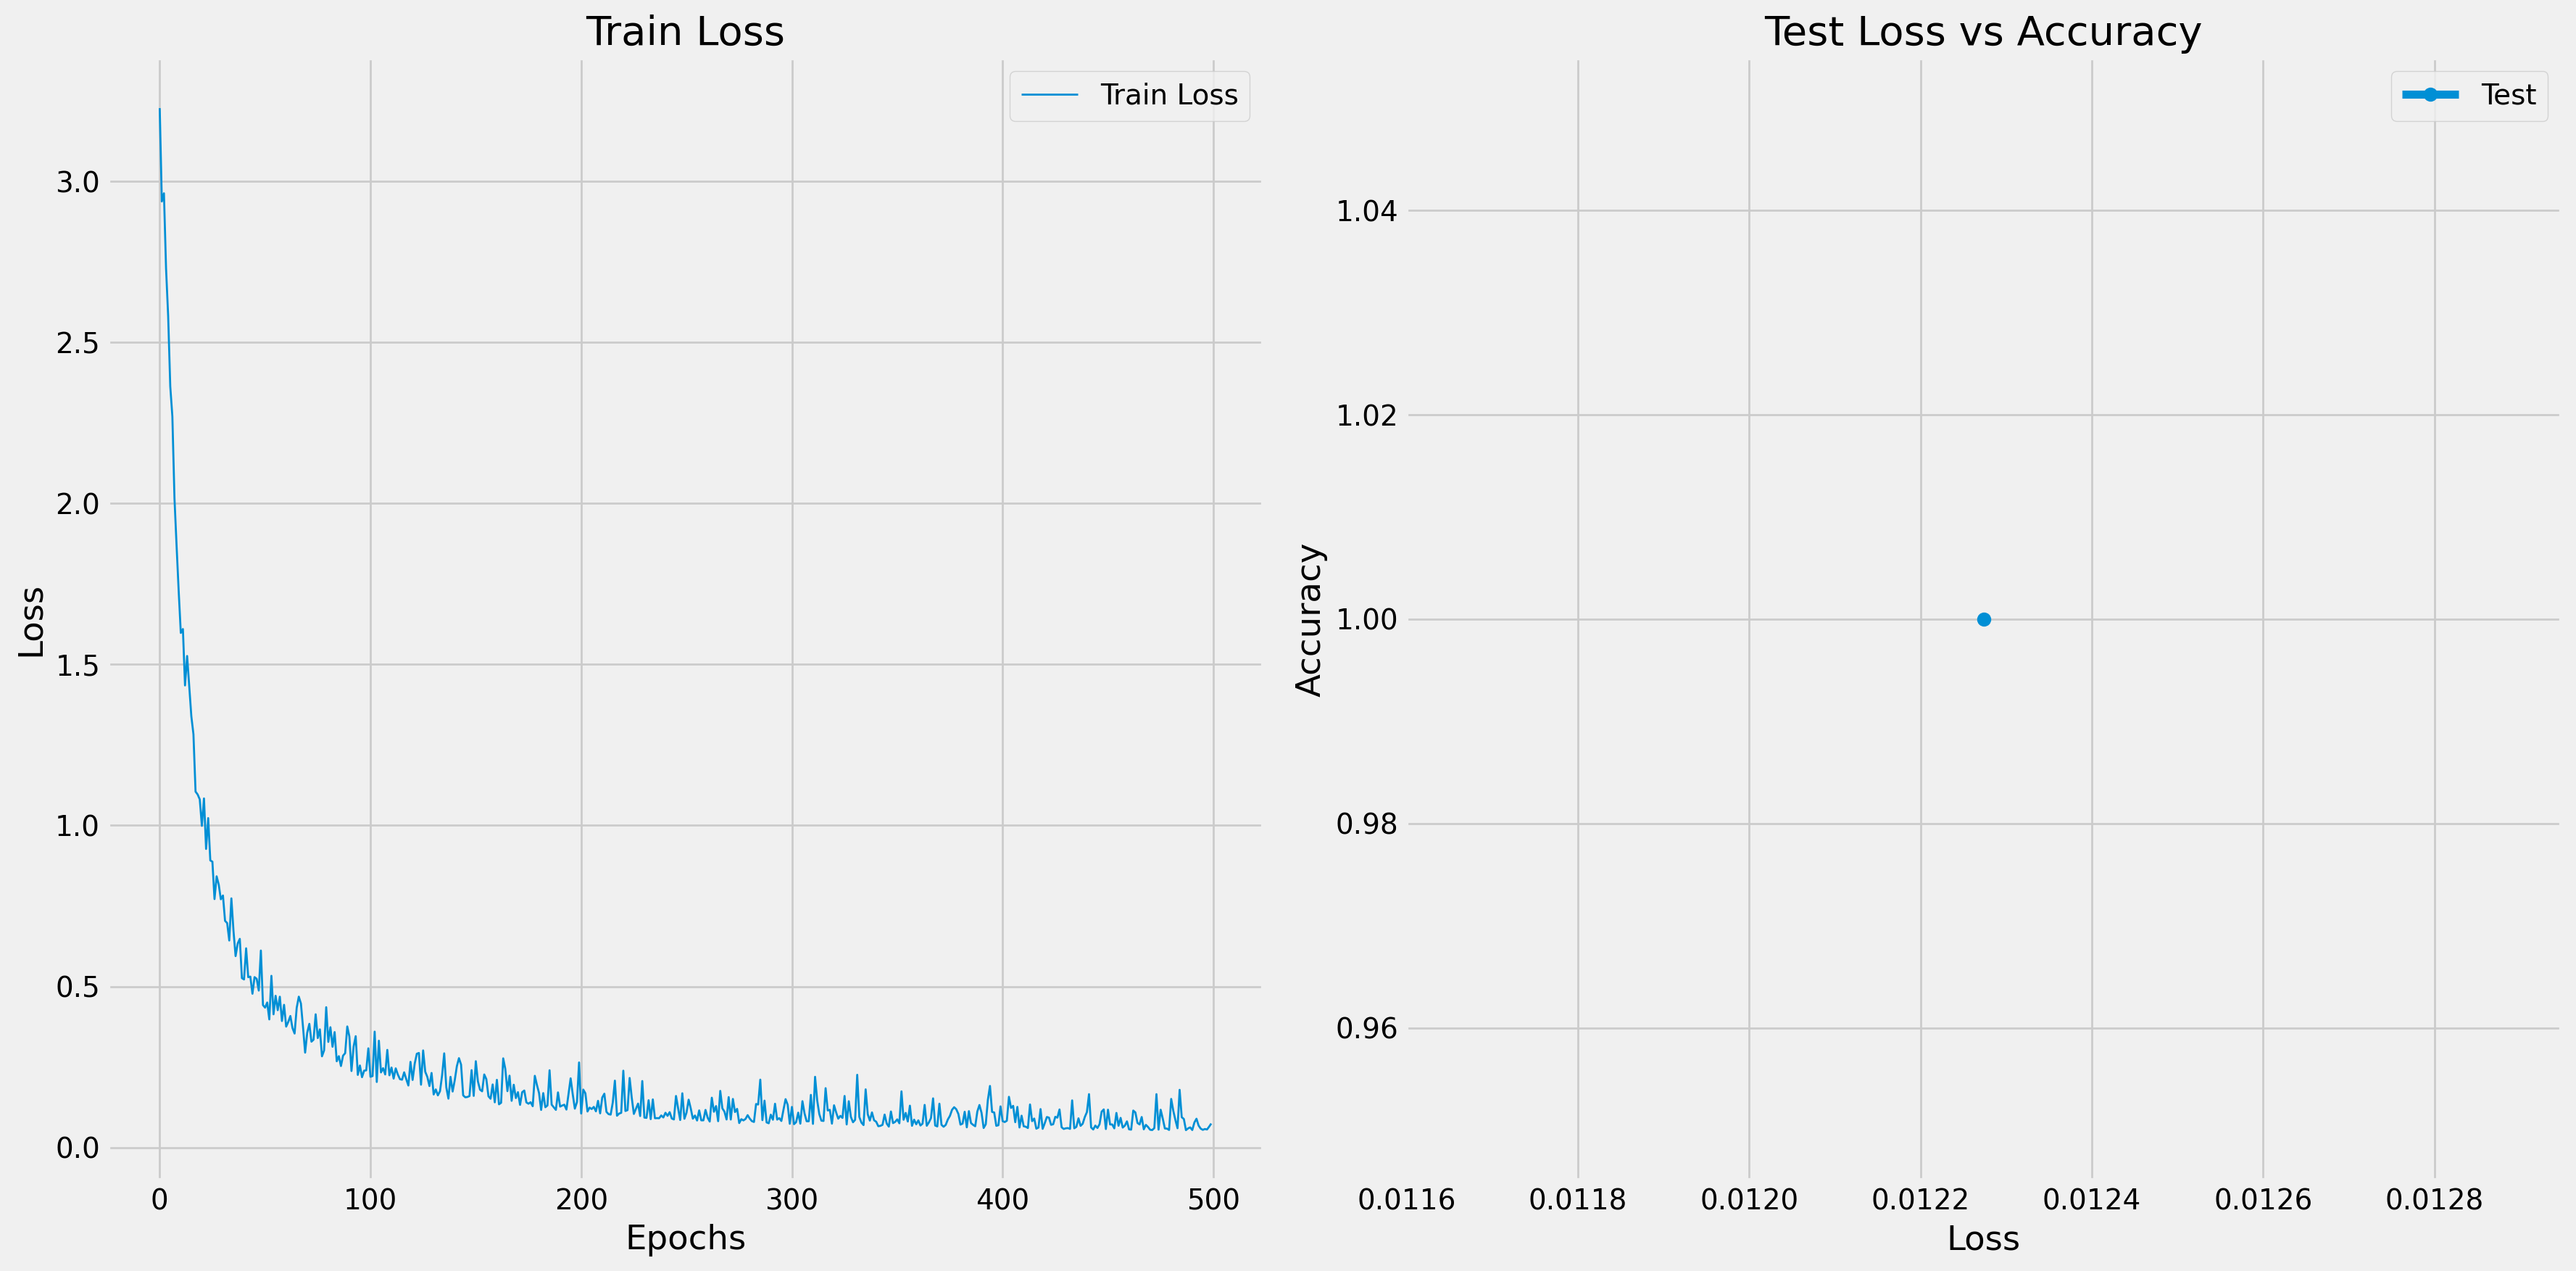

In [19]:
_, ax = plt.subplots(1, 2, figsize=(18, 9))
architecture = [input_features] + [32, 16] + [output_size]
model = MLP(architecture, activation='relu', dropout_p=0.01, use_l2=True)
criterion = get_loss_function(task=task)
optimizer = get_optimizer(model, optimizer_type='sgd', lr=0.001, momentum=0.1)
history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs = 500,
    patience = 20,
    l2_lambda = 0.001,
    task = task
)
test_loss, test_acc = evaluate_model(
    model, 
    test_loader, 
    criterion, 
    task = task
)
ax[0].plot(
    history['train_loss'], 
    label = 'Train Loss',
    linewidth = 1
)
ax[1].plot(
    [test_loss],
    [test_acc],
    label = 'Test',
    marker = 'o',
)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Train Loss')
ax[0].legend()
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Test Loss vs Accuracy')
ax[1].legend()
plt.tight_layout()

# 3.2

In [20]:
def prepare_classification_data(X_train, y_train, X_val=None, y_val=None, X_test=None, y_test=None, val_size=0.2, batch_size=32, task='binary', convert_labels=False):
    if X_val is None or y_val is None:
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, 
            test_size=val_size,
            random_state=42, 
            stratify=y_train
        )
    if X_test is None or y_test is None:
        X_train, X_test, y_train, y_test = train_test_split(
            X_train, y_train, 
            test_size=0.2,
            random_state=42, 
            stratify=y_train
        )
    if convert_labels and task.lower() == 'binary':
        y_train = (y_train == 1).astype(int)
        y_val = (y_val == 1).astype(int)
        y_test = (y_test == 1).astype(int)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    X_train_tensor = torch.FloatTensor(X_train)
    X_val_tensor = torch.FloatTensor(X_val)
    X_test_tensor = torch.FloatTensor(X_test)
    if task.lower() == 'binary':
        y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
        y_val_tensor = torch.FloatTensor(y_val).view(-1, 1)
        y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)
    else:
        y_train_tensor = torch.LongTensor(y_train)
        y_val_tensor = torch.LongTensor(y_val)
        y_test_tensor = torch.LongTensor(y_test)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    return train_loader, val_loader, test_loader

In [21]:
train = pd.read_csv("../data/atividade_03/train_dataset.csv")
validation = pd.read_csv("../data/atividade_03/validation_dataset.csv")
test = pd.read_csv("../data/atividade_03/test_dataset.csv")

X_train = train.iloc[:, :-1].values
y_train = train.iloc[:, -1].values
X_val = validation.iloc[:, :-1].values
y_val = validation.iloc[:, -1].values
X_test = test.iloc[:, :-1].values
y_test = test.iloc[:, -1].values

task = 'multiclass'

## optimizers

Test Loss: 1.2528, Test Accuracy: 0.4458
Test Loss: 1.0945, Test Accuracy: 0.5208


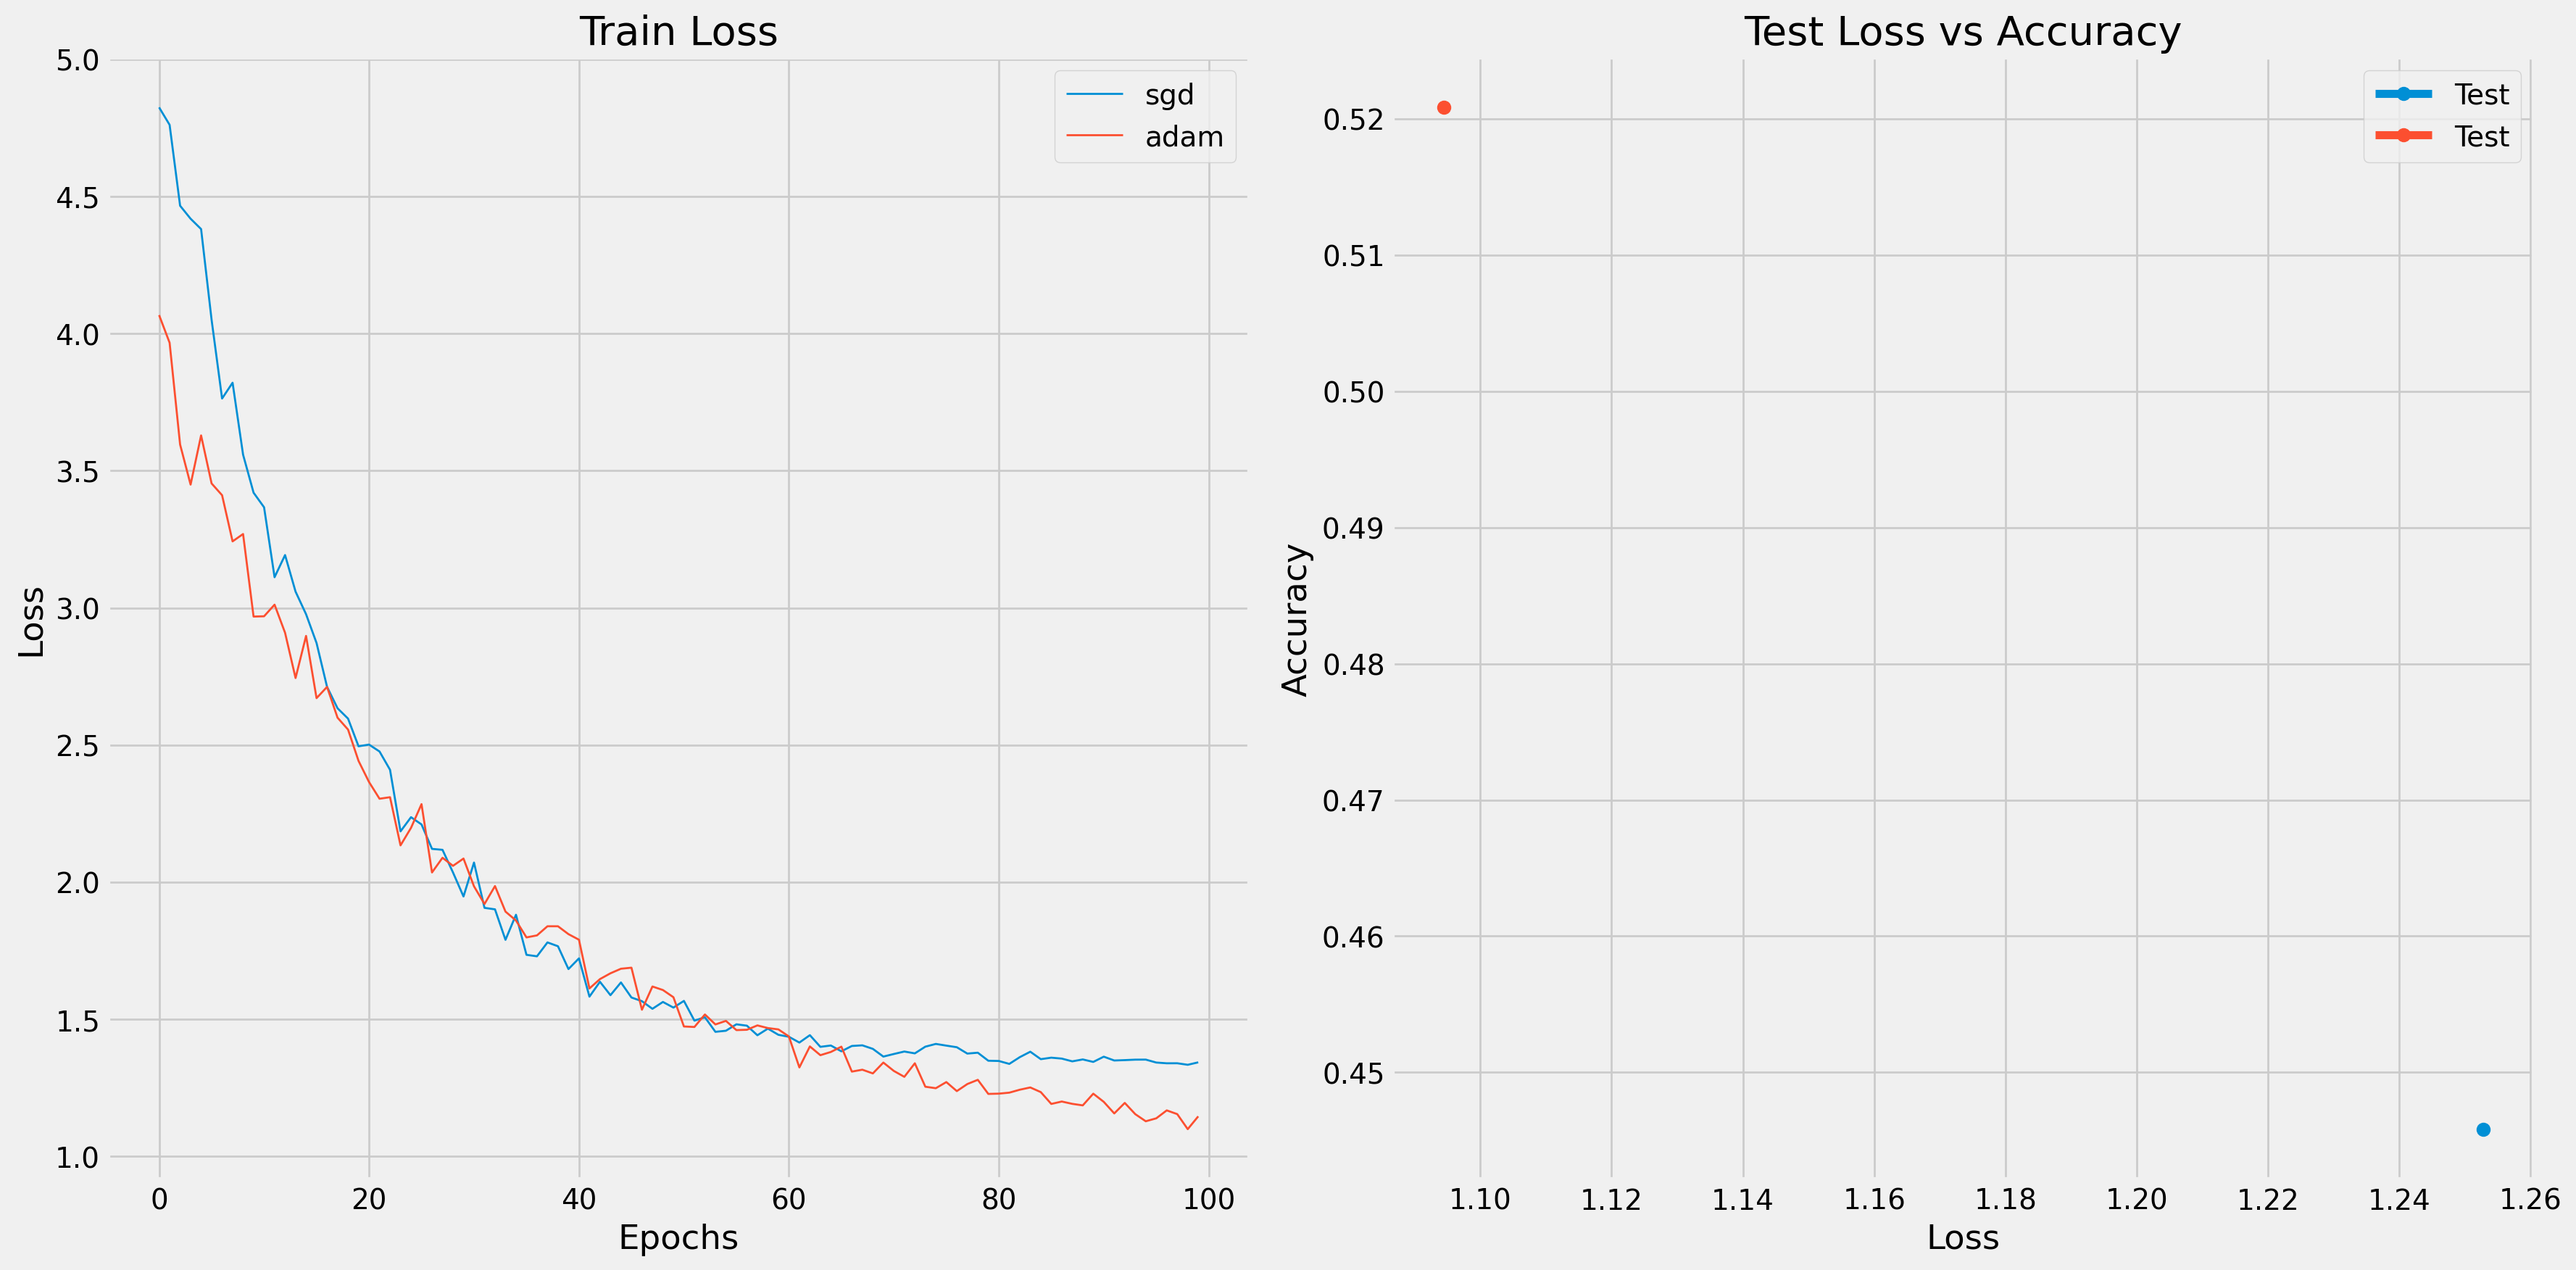

In [23]:
# sgd, eta=0.01
input_features = X_train.shape[1]
output_size = get_output_size(y_train, task=task)
train_loader, val_loader, test_loader = prepare_classification_data(
    X_train, 
    y_train, 
    X_val = X_val,
    y_val = y_val,
    X_test = X_test, 
    y_test = y_test,
    batch_size = 32,
    task=task,
    convert_labels = False
)
architecture = [input_features, 64, 16, output_size]
model = MLP(architecture, activation='tanh', dropout_p=0.2, use_l2=True)
criterion = get_loss_function(task=task)
optimizer = get_optimizer(model, optimizer_type='sgd', lr=0.01, momentum=0.09)
history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=100,
    patience=20,
    l2_lambda=0.001,
    task=task
)
test_loss, test_acc = evaluate_model(
    model, 
    test_loader, 
    criterion, 
    task=task
)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

_, ax = plt.subplots(1, 2, figsize=(18, 9))

ax[0].plot(
    history['train_loss'], 
    label = 'sgd',
    linewidth = 1
)
ax[1].plot(
    [test_loss],
    [test_acc],
    label = 'Test',
    marker = 'o',
)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Train Loss')
ax[0].legend()
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Test Loss vs Accuracy')
ax[1].legend()
plt.tight_layout()

# adam, eta=0.001
architecture = [input_features, 64, 16, output_size]
model = MLP(architecture, activation='tanh', dropout_p=0.2, use_l2=True)
criterion = get_loss_function(task=task)
optimizer = get_optimizer(model, optimizer_type='adam', lr=0.001, momentum=0.09)
history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=100,
    patience=20,
    l2_lambda=0.001,
    task=task
)
test_loss, test_acc = evaluate_model(
    model, 
    test_loader, 
    criterion, 
    task=task
)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

ax[0].plot(
    history['train_loss'], 
    label = 'adam',
    linewidth = 1
)
ax[1].plot(
    [test_loss],
    [test_acc],
    label = 'Test',
    marker = 'o',
)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Train Loss')
ax[0].legend()
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Test Loss vs Accuracy')
ax[1].legend()
plt.tight_layout()

<br/>

**pelos resultados é possível observar que o otimizador SGD é mais estável no treinamento.**

<br/>

## layers

 33%|███▎      | 1/3 [00:02<00:04,  2.36s/it]

Test Loss: 1.4588, Test Accuracy: 0.2875


 67%|██████▋   | 2/3 [00:05<00:02,  2.55s/it]

Test Loss: 1.5992, Test Accuracy: 0.2583


100%|██████████| 3/3 [00:07<00:00,  2.35s/it]

early stopping na época 62
Test Loss: 1.7362, Test Accuracy: 0.3000


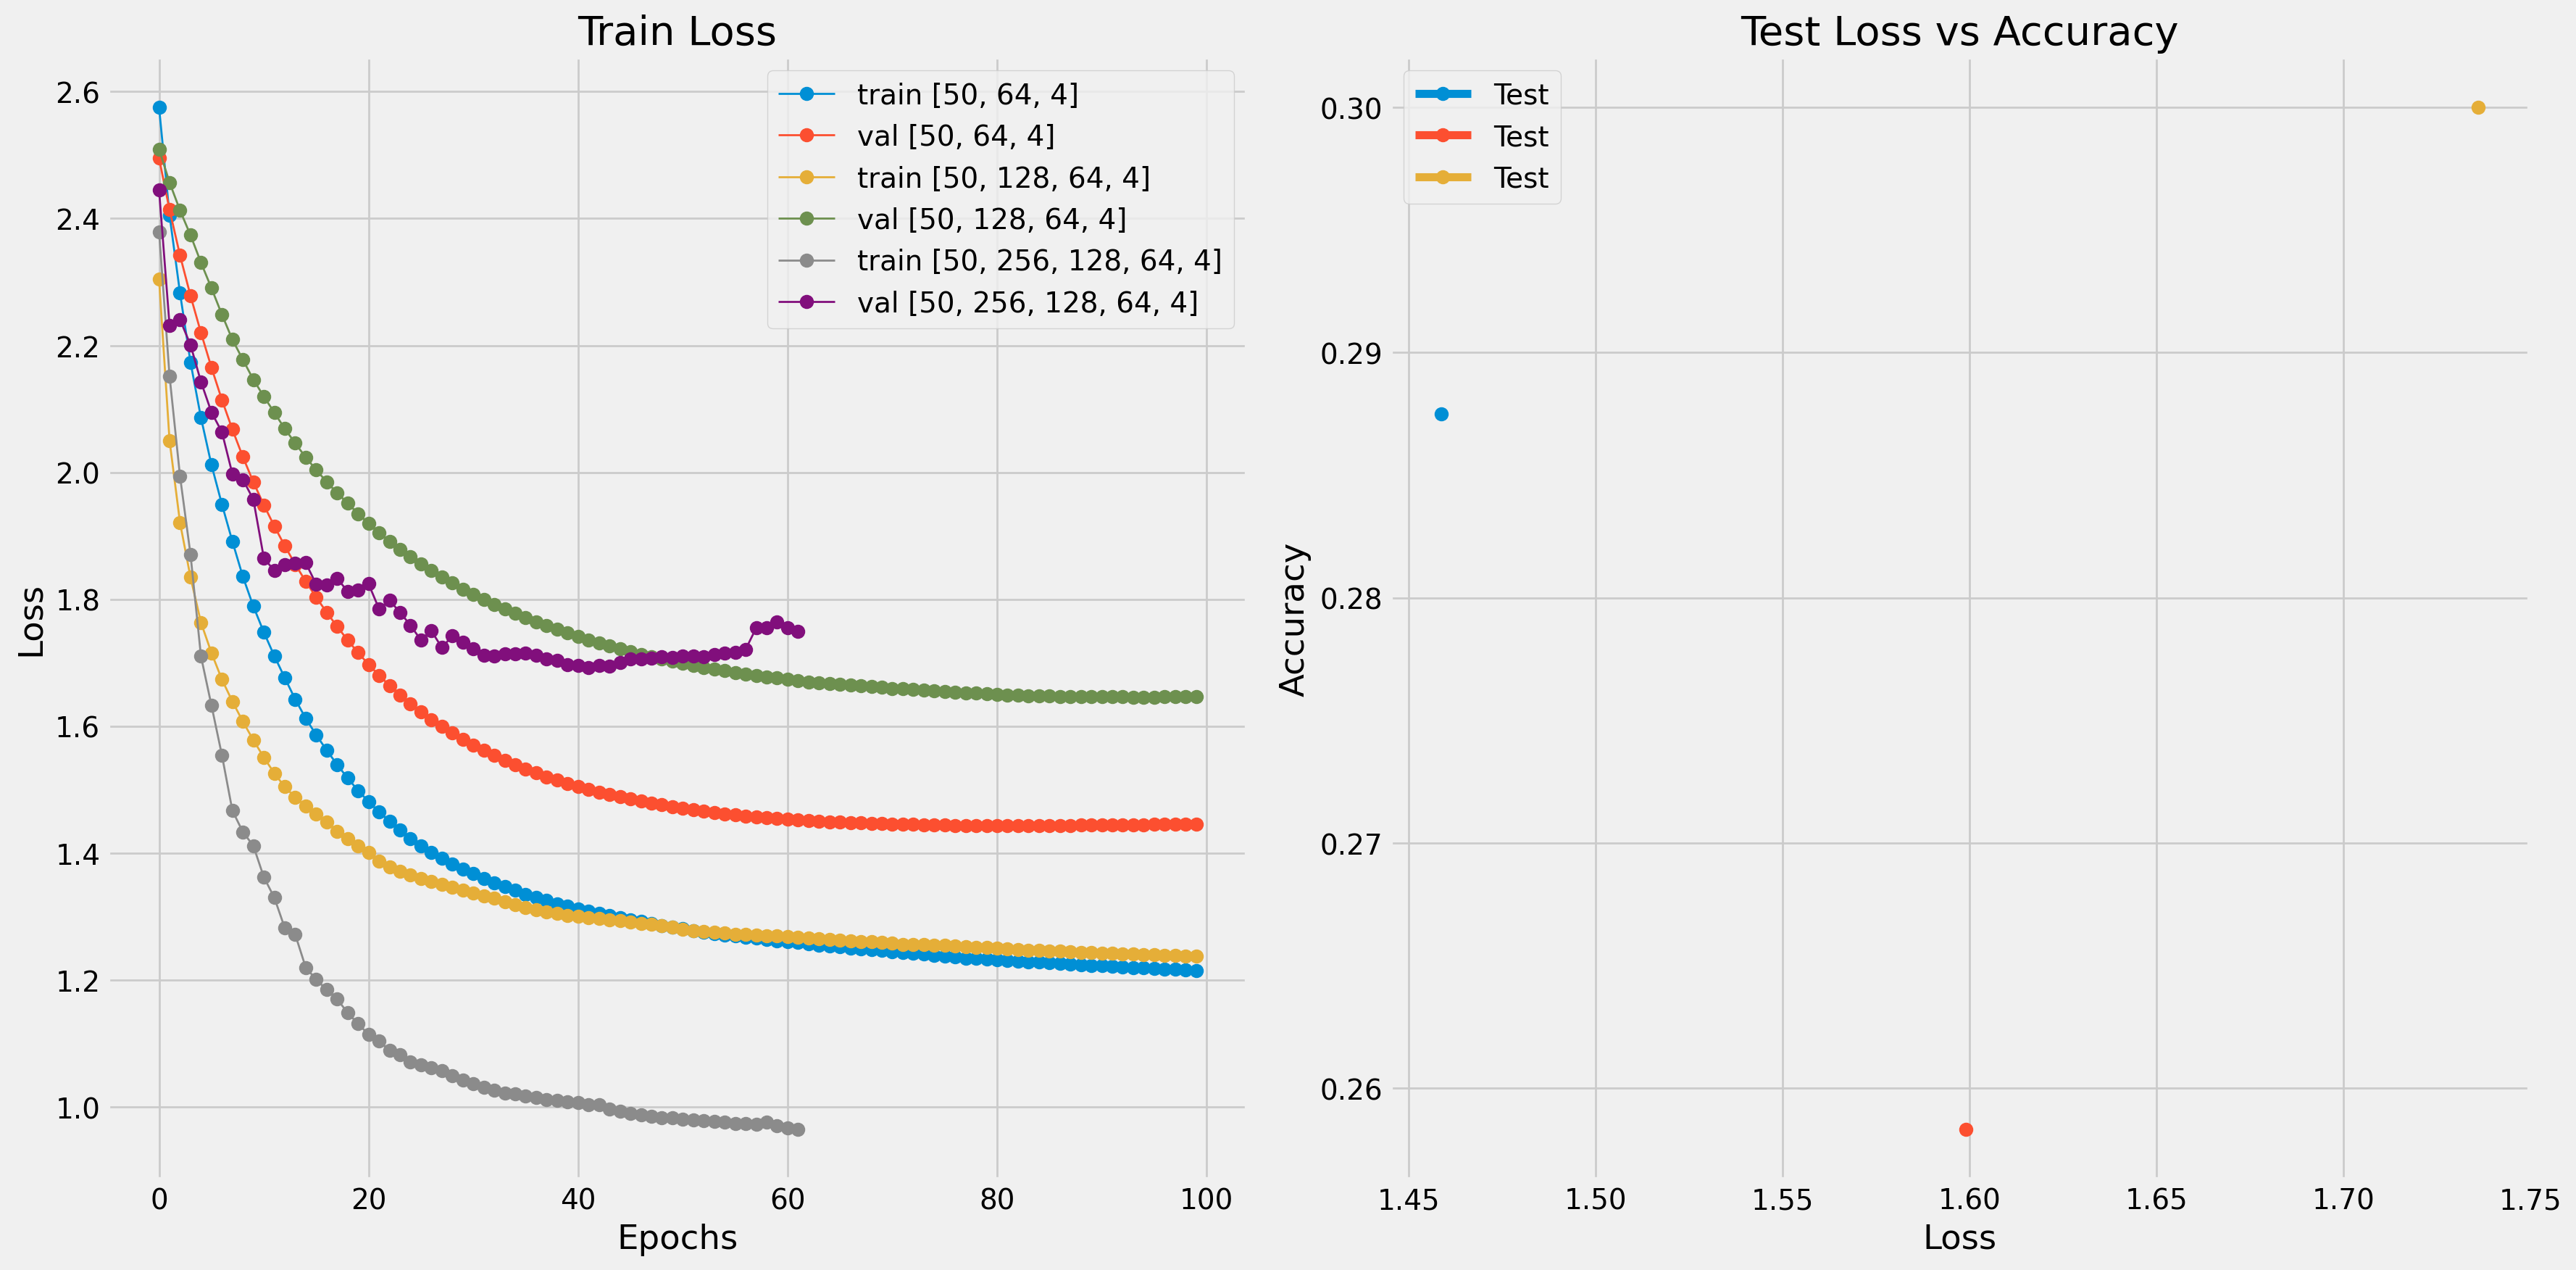

In [31]:
_, ax = plt.subplots(1, 2, figsize=(18, 9))

for i in tqdm.tqdm([
    [50, 64, 4],
    [50, 128, 64, 4],
    [50, 256, 128, 64, 4],
    ]):
    input_features = X_train.shape[1]
    output_size = get_output_size(y_train, task=task)
    train_loader, val_loader, test_loader = prepare_classification_data(
        X_train, 
        y_train, 
        X_val = X_val,
        y_val = y_val,
        X_test = X_test, 
        y_test = y_test,
        batch_size = 32,
        task=task,
        convert_labels = False
    )
    architecture = [input_features] + i + [output_size]
    model = MLP(architecture, activation='tanh', dropout_p=0.0, use_l2=False)
    criterion = get_loss_function(task=task)
    optimizer = get_optimizer(model, optimizer_type='sgd', lr=0.01, momentum=0.09)
    history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        epochs=100,
        patience=20,
        l2_lambda=0.000,
        task=task
    )
    test_loss, test_acc = evaluate_model(
        model, 
        test_loader, 
        criterion, 
        task=task
    )
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    ax[0].plot(
        history['train_loss'], 
        label = f"train {i}",
        linewidth = 1,
        marker = 'o',
    )
    ax[0].plot(
        history['val_loss'], 
        label = f"val {i}",
        linewidth = 1,
        marker = 'o',
    )
    ax[1].plot(
        [test_loss],
        [test_acc],
        label = 'Test',
        marker = 'o',
    )
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Train Loss')
    ax[0].legend()
    ax[1].set_xlabel('Loss')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Test Loss vs Accuracy')
    ax[1].legend()
    plt.tight_layout()

<br/>

**pelos resultados é possível observar que quanto maior a quantidade de camadas escondidas, maior o overfitting (maior o distanciamento entre treinamento e validação); arquiteturas com menos camadas ocultas produzem menor overffiting, em particular a arquitetura "50-64-4" produz o melhor balanço entre loss e acurácia.**

<br/>

## regularization

Test Loss: 1.7254, Test Accuracy: 0.3167
Test Loss: 1.2008, Test Accuracy: 0.4917
Test Loss: 1.5347, Test Accuracy: 0.4417


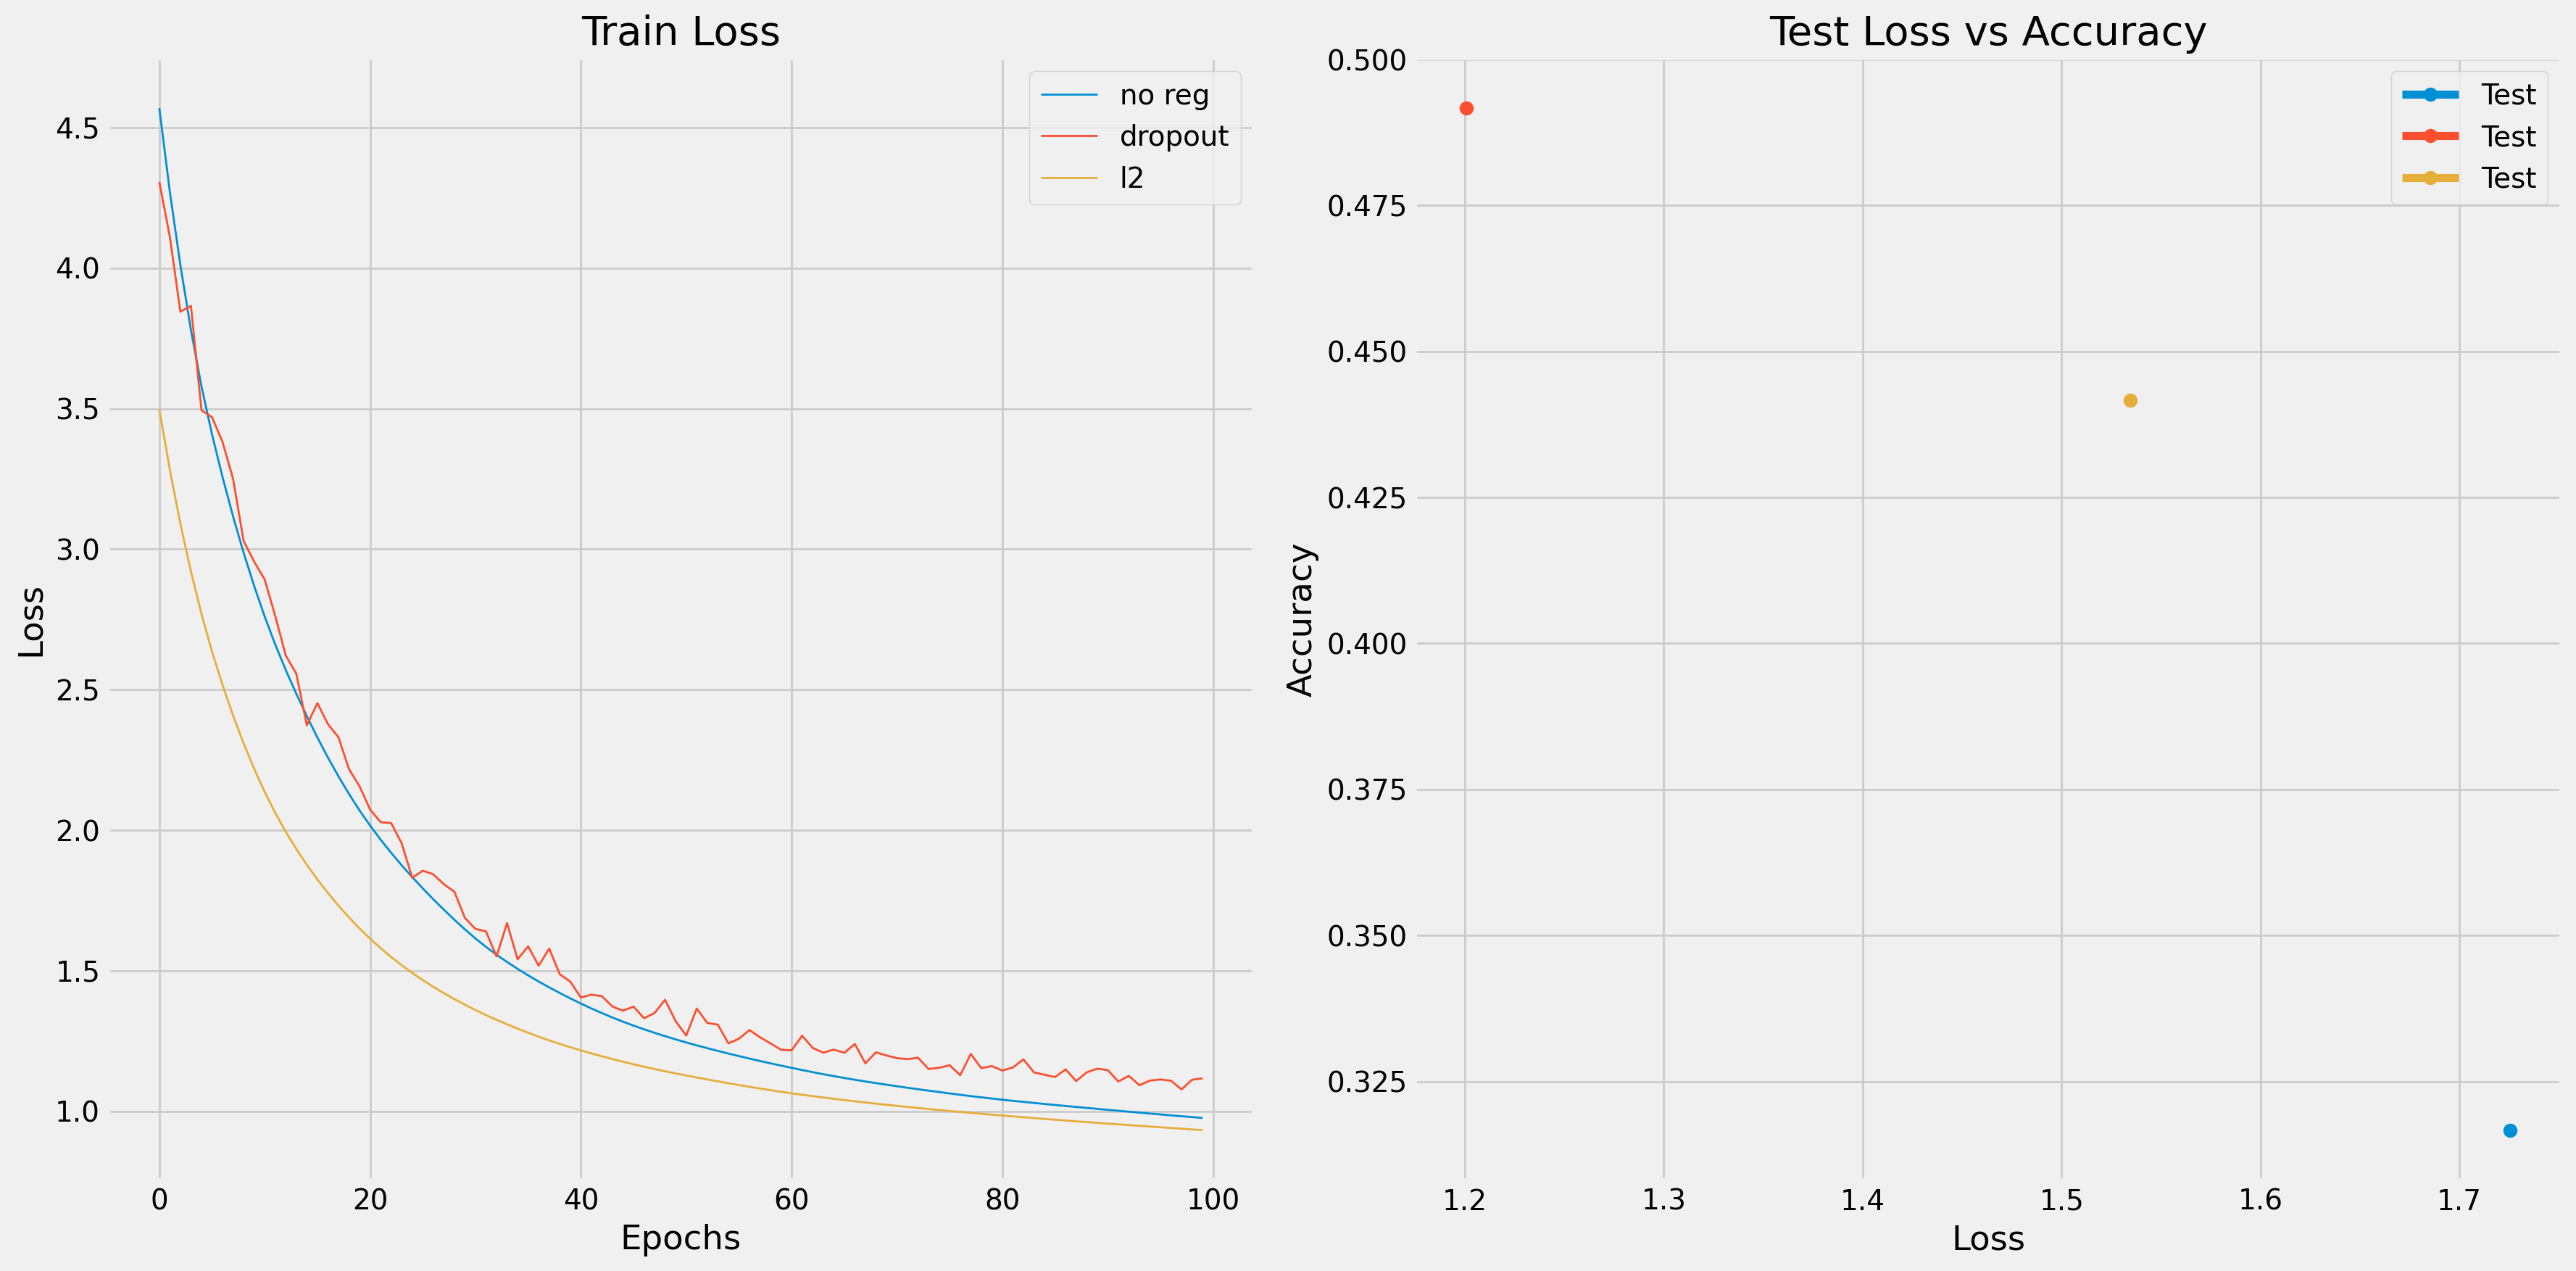

In [35]:
# no reg
input_features = X_train.shape[1]
output_size = get_output_size(y_train, task=task)
train_loader, val_loader, test_loader = prepare_classification_data(
    X_train, 
    y_train, 
    X_val = X_val,
    y_val = y_val,
    X_test = X_test, 
    y_test = y_test,
    batch_size = 32,
    task=task,
    convert_labels = False
)
architecture = [input_features, 64, 16, output_size]
model = MLP(architecture, activation='tanh', dropout_p=0.0, use_l2=False)
criterion = get_loss_function(task=task)
optimizer = get_optimizer(model, optimizer_type='sgd', lr=0.01, momentum=0.09)
history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=100,
    patience=20,
    l2_lambda=0.000,
    task=task
)
test_loss, test_acc = evaluate_model(
    model, 
    test_loader, 
    criterion, 
    task=task
)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

_, ax = plt.subplots(1, 2, figsize=(18, 9))

ax[0].plot(
    history['train_loss'], 
    label = 'no reg',
    linewidth = 1
)
ax[1].plot(
    [test_loss],
    [test_acc],
    label = 'Test',
    marker = 'o',
)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Train Loss')
ax[0].legend()
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Test Loss vs Accuracy')
ax[1].legend()

# dropout
input_features = X_train.shape[1]
output_size = get_output_size(y_train, task=task)
train_loader, val_loader, test_loader = prepare_classification_data(
    X_train, 
    y_train, 
    X_val = X_val,
    y_val = y_val,
    X_test = X_test, 
    y_test = y_test,
    batch_size = 32,
    task=task,
    convert_labels = False
)
architecture = [input_features, 64, 16, output_size]
model = MLP(architecture, activation='tanh', dropout_p=0.1, use_l2=False)
criterion = get_loss_function(task=task)
optimizer = get_optimizer(model, optimizer_type='sgd', lr=0.01, momentum=0.09)
history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=100,
    patience=20,
    l2_lambda=0.000,
    task=task
)
test_loss, test_acc = evaluate_model(
    model, 
    test_loader, 
    criterion, 
    task=task
)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

ax[0].plot(
    history['train_loss'], 
    label = 'dropout',
    linewidth = 1
)
ax[1].plot(
    [test_loss],
    [test_acc],
    label = 'Test',
    marker = 'o',
)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Train Loss')
ax[0].legend()
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Test Loss vs Accuracy')
ax[1].legend()

# l2
input_features = X_train.shape[1]
output_size = get_output_size(y_train, task=task)
train_loader, val_loader, test_loader = prepare_classification_data(
    X_train, 
    y_train, 
    X_val = X_val,
    y_val = y_val,
    X_test = X_test, 
    y_test = y_test,
    batch_size = 32,
    task=task,
    convert_labels = False
)
architecture = [input_features, 64, 16, output_size]
model = MLP(architecture, activation='tanh', dropout_p=0.0, use_l2=True)
criterion = get_loss_function(task=task)
optimizer = get_optimizer(model, optimizer_type='sgd', lr=0.01, momentum=0.09)
history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=100,
    patience=20,
    l2_lambda=0.001,
    task=task
)
test_loss, test_acc = evaluate_model(
    model, 
    test_loader, 
    criterion, 
    task=task
)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

ax[0].plot(
    history['train_loss'], 
    label = 'l2',
    linewidth = 1
)
ax[1].plot(
    [test_loss],
    [test_acc],
    label = 'Test',
    marker = 'o',
)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Train Loss')
ax[0].legend()
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Test Loss vs Accuracy')
ax[1].legend()

plt.tight_layout()

<br/>

**pelos resultados é possível observar que, embora produza losses marginalmente maiores comparativamente, o dropout se provou a estratégia que produz maior acurácia no conjunto de teste, além de menor loss.**

<br/>

## activation

Test Loss: 1.3524, Test Accuracy: 0.3292
Test Loss: 1.2530, Test Accuracy: 0.4542


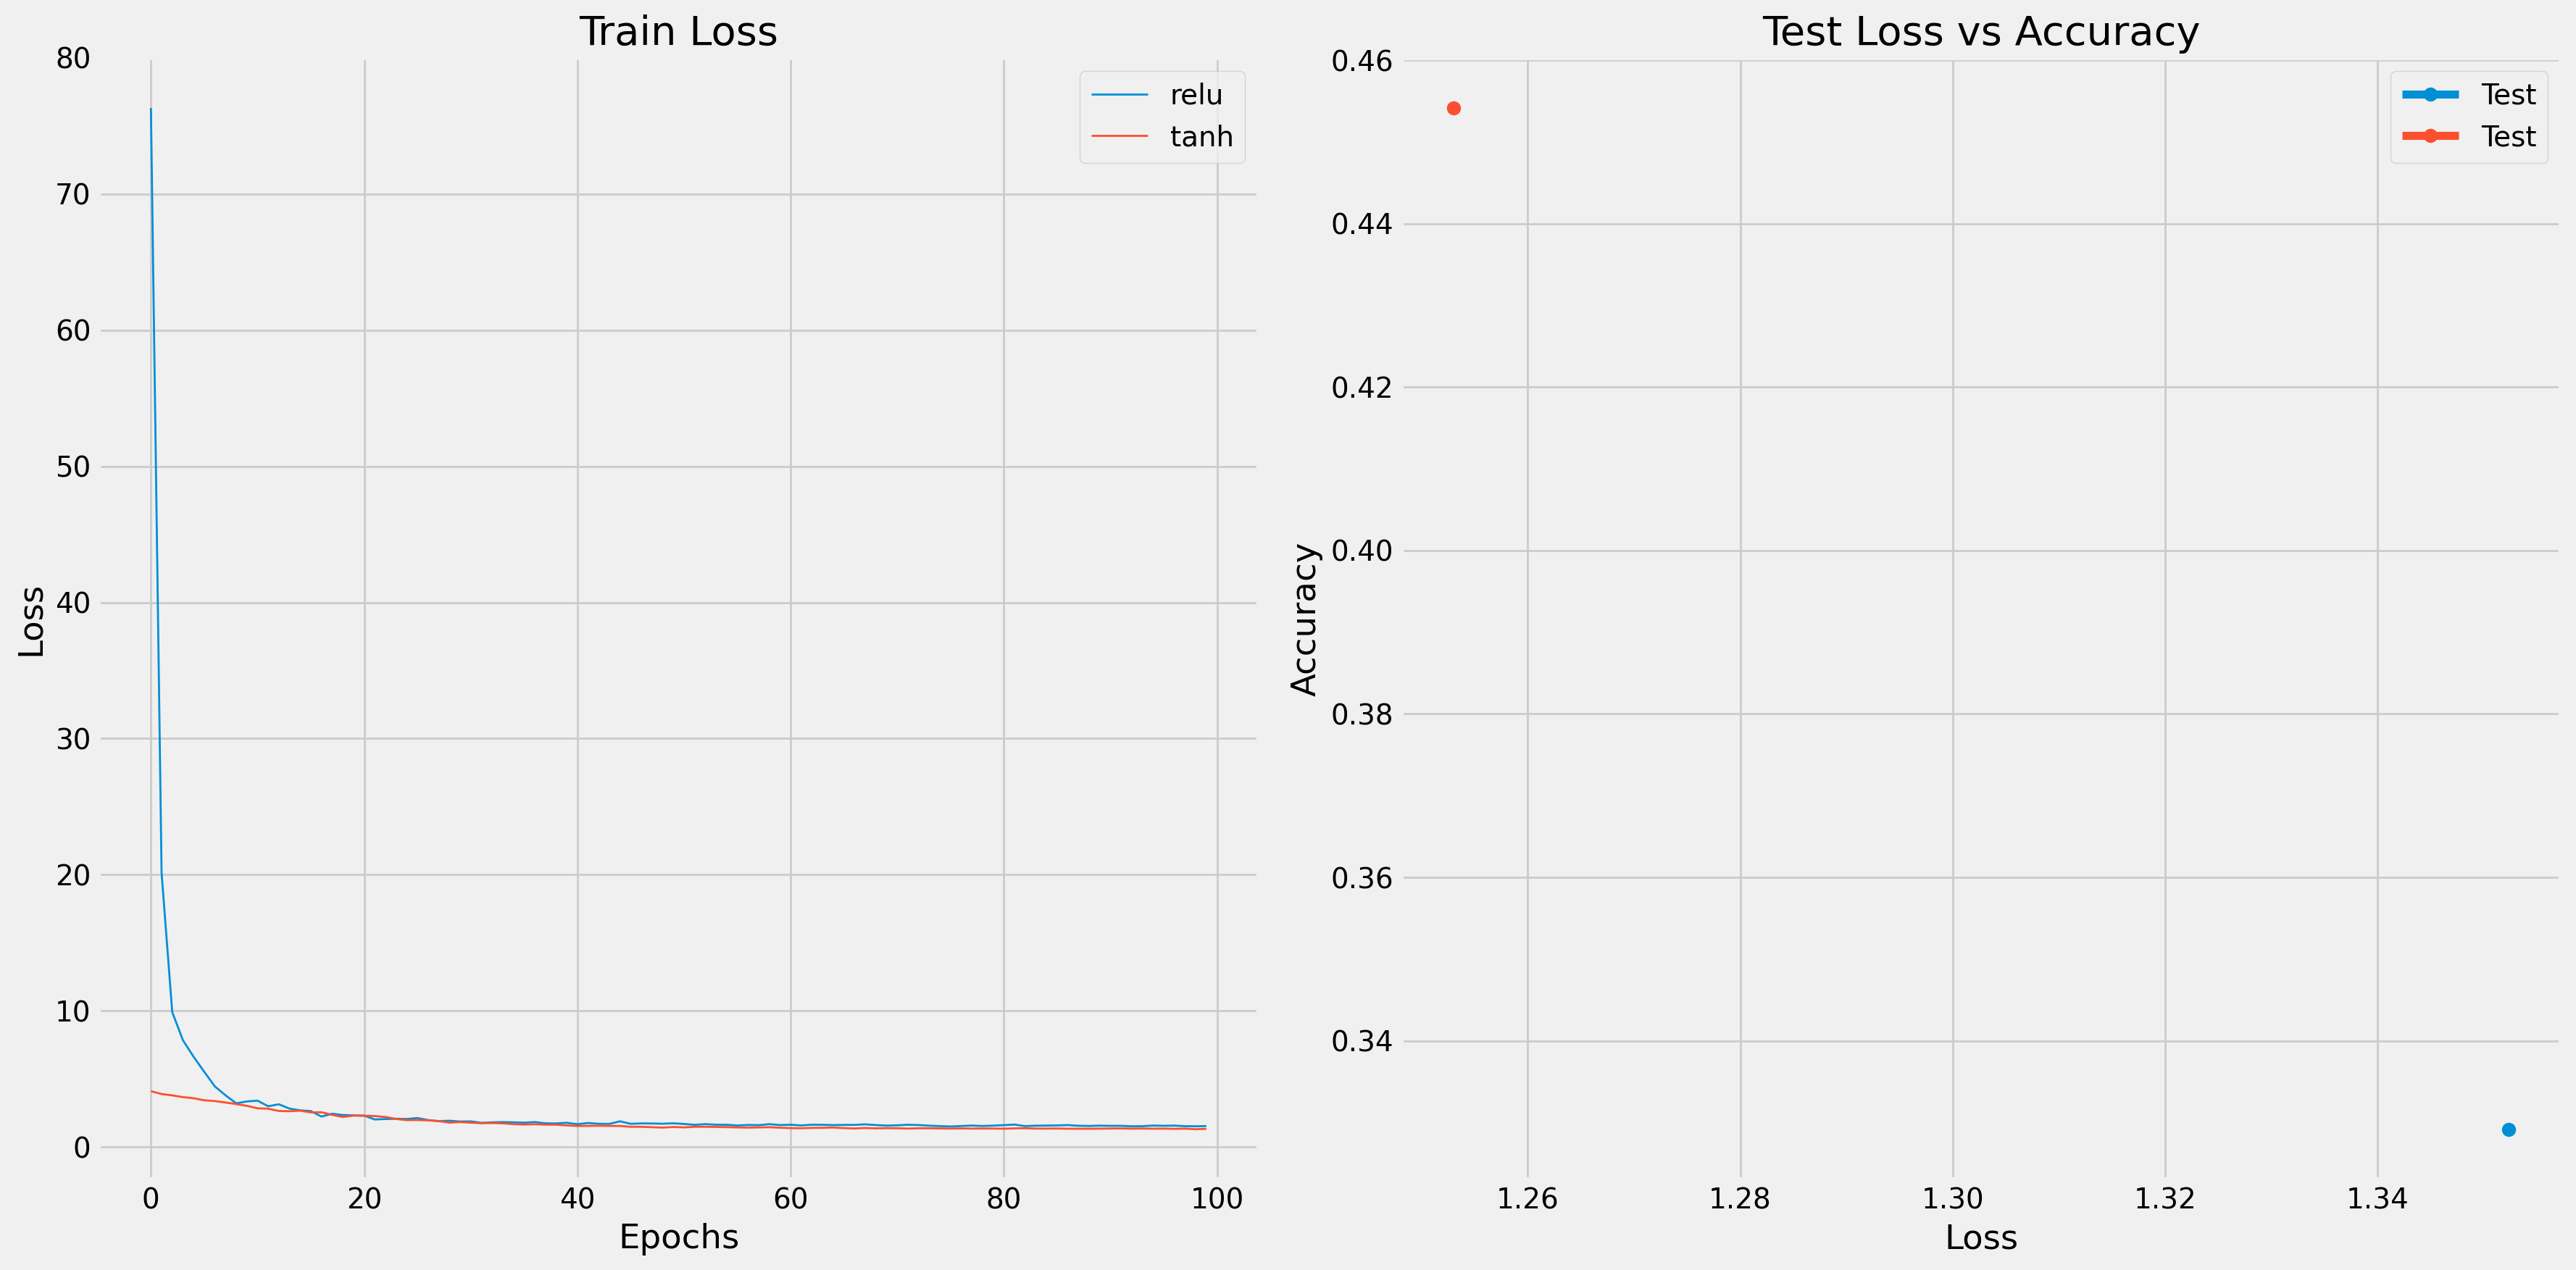

In [36]:
# relu
input_features = X_train.shape[1]
output_size = get_output_size(y_train, task=task)
train_loader, val_loader, test_loader = prepare_classification_data(
    X_train, 
    y_train, 
    X_val = X_val,
    y_val = y_val,
    X_test = X_test, 
    y_test = y_test,
    batch_size = 32,
    task=task,
    convert_labels = False
)
architecture = [input_features, 64, 16, output_size]
model = MLP(architecture, activation='relu', dropout_p=0.2, use_l2=True)
criterion = get_loss_function(task=task)
optimizer = get_optimizer(model, optimizer_type='sgd', lr=0.01, momentum=0.09)
history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=100,
    patience=20,
    l2_lambda=0.001,
    task=task
)
test_loss, test_acc = evaluate_model(
    model, 
    test_loader, 
    criterion, 
    task=task
)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

_, ax = plt.subplots(1, 2, figsize=(18, 9))

ax[0].plot(
    history['train_loss'], 
    label = 'relu',
    linewidth = 1
)
ax[1].plot(
    [test_loss],
    [test_acc],
    label = 'Test',
    marker = 'o',
)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Train Loss')
ax[0].legend()
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Test Loss vs Accuracy')
ax[1].legend()

# tanh
architecture = [input_features, 64, 16, output_size]
model = MLP(architecture, activation='tanh', dropout_p=0.2, use_l2=True)
criterion = get_loss_function(task=task)
optimizer = get_optimizer(model, optimizer_type='sgd', lr=0.01, momentum=0.09)
history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=100,
    patience=20,
    l2_lambda=0.001,
    task=task
)
test_loss, test_acc = evaluate_model(
    model, 
    test_loader, 
    criterion, 
    task=task
)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

ax[0].plot(
    history['train_loss'], 
    label = 'tanh',
    linewidth = 1
)
ax[1].plot(
    [test_loss],
    [test_acc],
    label = 'Test',
    marker = 'o',
)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Train Loss')
ax[0].legend()
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Test Loss vs Accuracy')
ax[1].legend()
plt.tight_layout()

<br/>

**pelos resultados é possível observar que, ambas as funções de ativação convergem para valores similares, contudo a tangente hiperbólica produz um modelo com maior poder de generalização**

<br/>